# TP2 - Machine Leaning 2
---
MOUSSA DIEME ISE 2

>Consigne 
 - Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc) 
- Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)
-  Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)
- Faire l'analyse des personnas pour le meilleur modèle
- Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)
---


## Import librairies

In [171]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer


## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [172]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [173]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

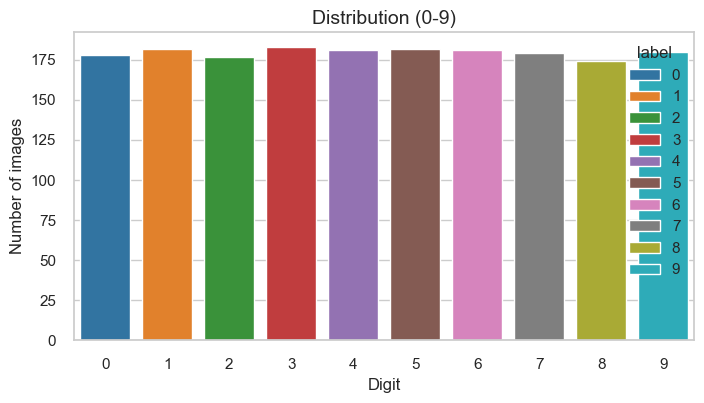

In [174]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, hue='label', palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

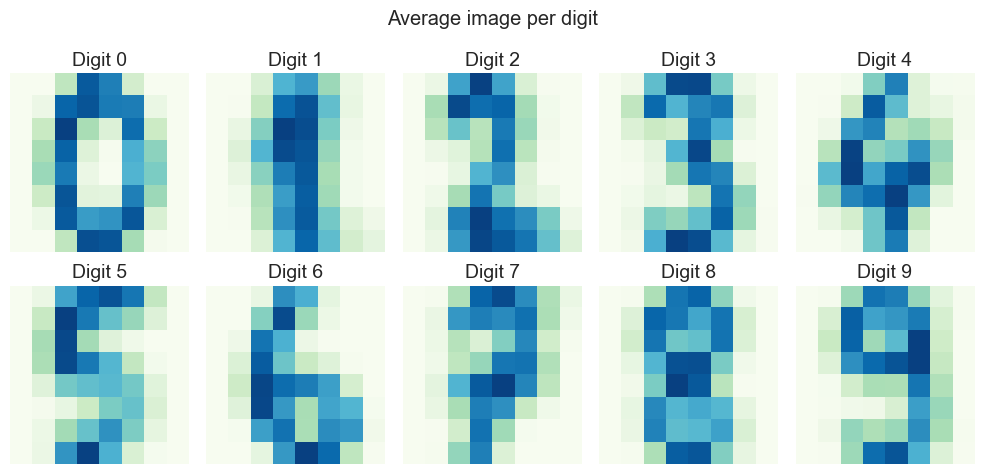

In [175]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='GnBu')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

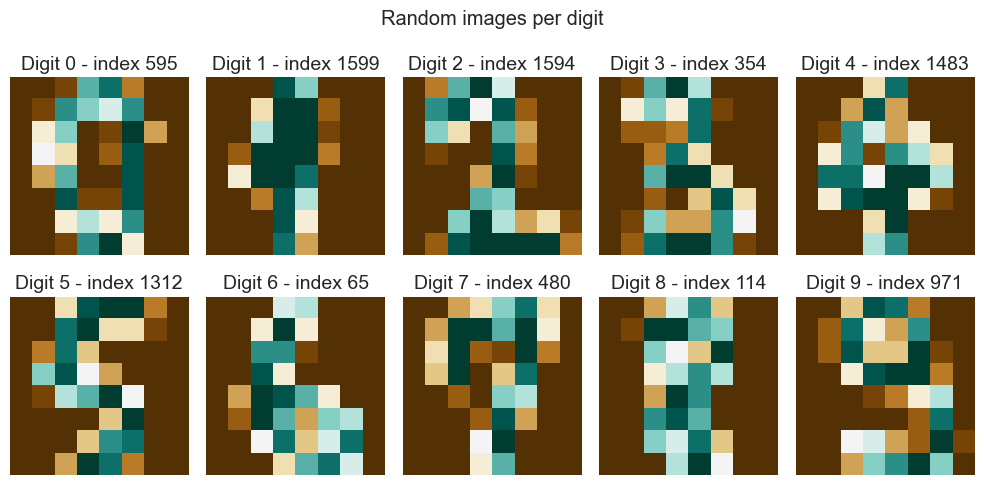

In [176]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='BrBG')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

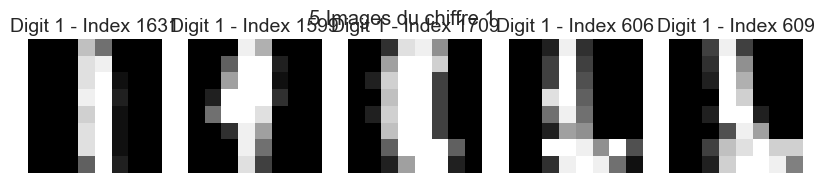

In [177]:
def show_digit_images(digit, n=5):
    """
    Affiche n images d'un chiffre spécifique du dataset digits.

    Paramètres :
    - digit : le chiffre à afficher (de 0 à 9).
    - n : nombre d'images à afficher.
    """
    idxs = np.random.choice(np.where(labels == digit)[0], size=n, replace=False)
    
    fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
    for i, idx in enumerate(idxs):
        axs[i].imshow(images[idx], cmap='gray')
        axs[i].set_title(f"Digit {digit} - Index {idx}")
        axs[i].axis('off')

    plt.suptitle(f"{n} Images du chiffre {digit}")
    plt.show()

show_digit_images(1, n=5)

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [178]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=1797,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [179]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=7, random_state=221)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=7, random_state=221)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.082s	4648	0.738	0.746	0.742	0.668	0.183
random   	0.035s	4647	0.741	0.750	0.745	0.669	0.183
PCA-based	0.021s	4647	0.744	0.753	0.749	0.673	0.183
__________________________________________________________________________________


## Optimal number of clusters

In [180]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

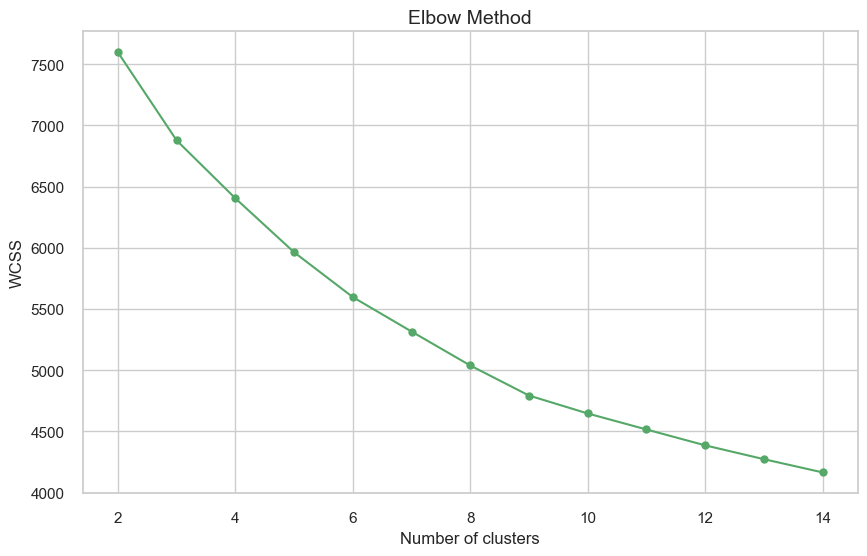

In [181]:
wcss = []  # Within-Cluster Sum of Squares 

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

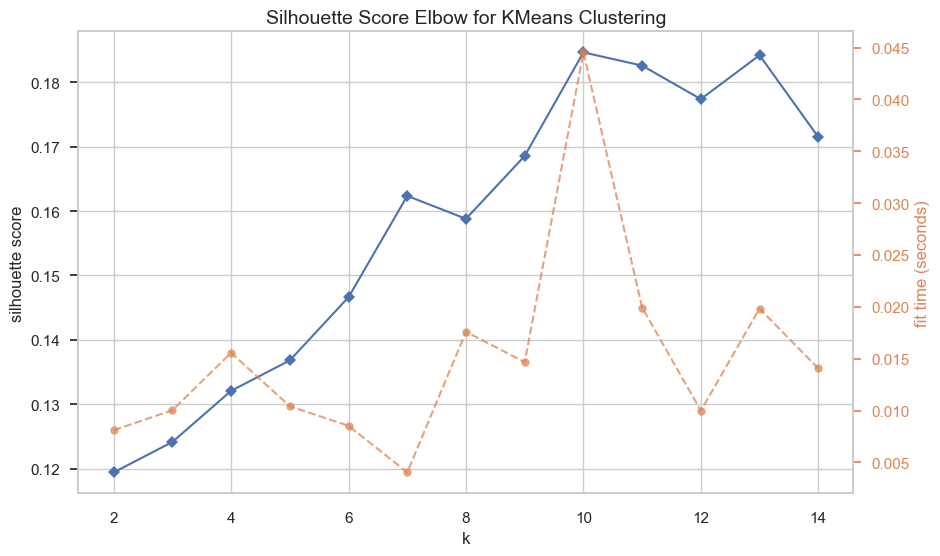

In [182]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [183]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [184]:
pd.DataFrame(reduced_data).head()

,0,1
0,-1.259466,-21.274883
1,7.957611,20.768699
2,6.991923,9.955986
3,-15.906105,-3.332464
4,23.306867,-4.269061


In [185]:
data["cluster"] = kmean_labels
data[['label','cluster']].head()

,label,cluster
0,0,6
1,1,5
2,2,8
3,3,0
4,4,7


In [186]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,0,3,96,0,1,0,0,0,39
1,15,0,0,0,16,5,143,0,0,1
2,0,9,8,12,3,25,0,117,24,9
3,1,29,34,11,0,46,0,1,71,17
4,4,6,4,21,0,46,0,0,8,96
5,0,88,1,0,8,0,0,20,4,0
6,157,0,0,0,0,6,7,0,0,0
7,1,2,0,0,149,2,29,0,1,0
8,0,48,12,0,5,48,2,40,62,10


In [187]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    3
1    6
2    7
3    8
4    9
5    1
6    0
7    4
8    8
9    2
dtype: int64


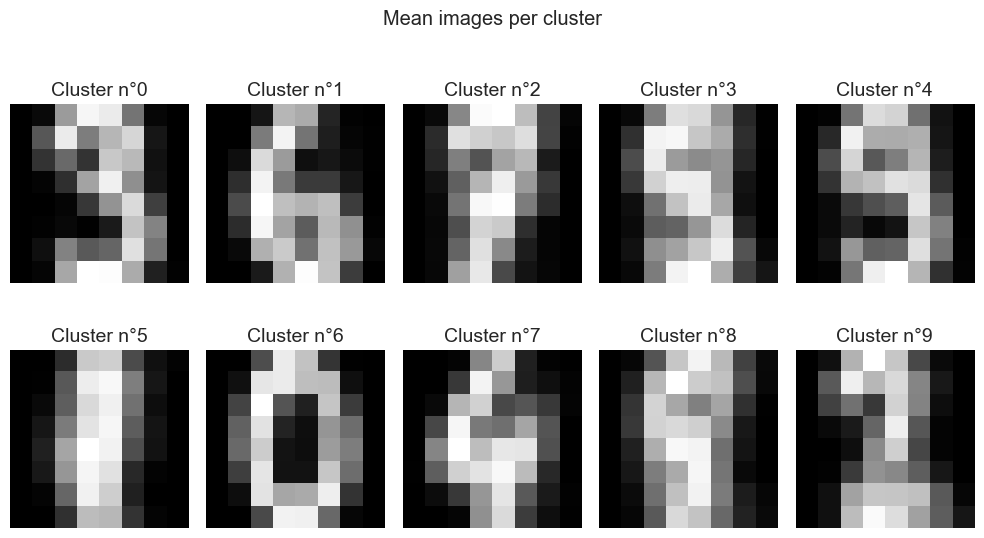

In [188]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

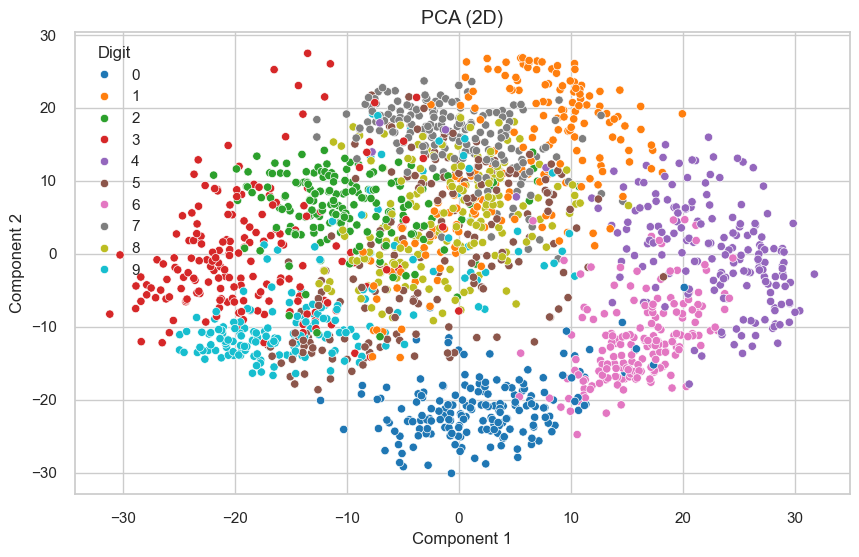

In [189]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


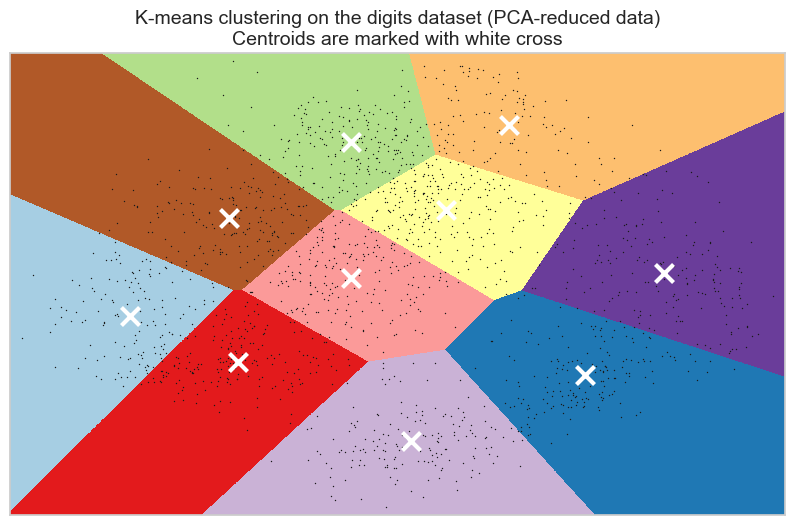

In [190]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

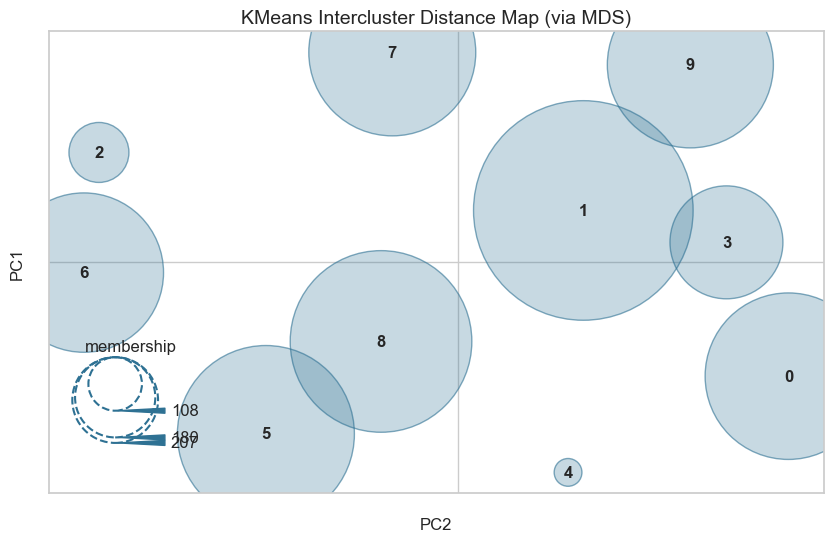

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [191]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [192]:
# Initialize

from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


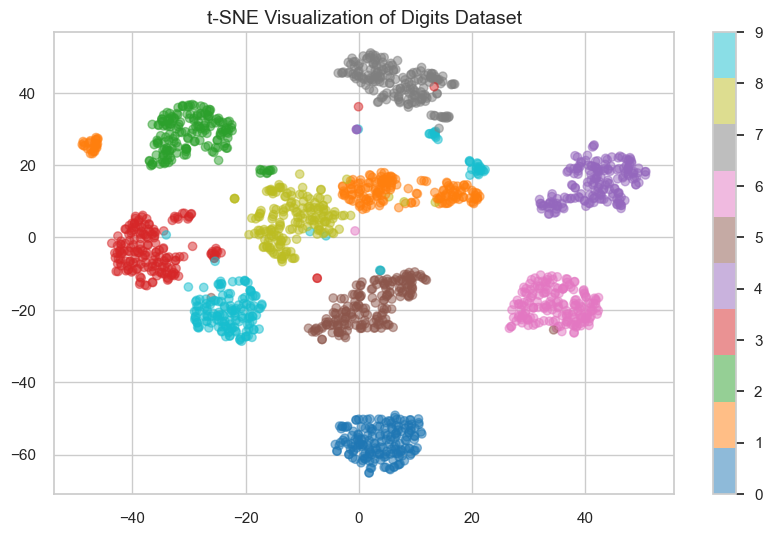

In [193]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.colorbar()
plt.title("t-SNE Visualization of Digits Dataset")
plt.show()

---

# TP --- 
>Ma contribution

In [194]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid


## Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc) 

In [195]:
# Nous allons legerement modifier bench_k_mean pour  y inclure un return afin de capter ses sorties
# output : une liste
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=1797, # On prend tous le monde
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results
    

In [196]:

# Standardisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [5,10,15,20],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=222, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=5, max_iter=100, tol=0.001	0.056s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-05	0.053s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-06	0.042s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-07	0.061s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-10	0.049s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=0.001	0.139s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-05	0.111s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-06	0.129s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-07	0.120s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-10	0.342s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-me

In [197]:
df.iloc[0]['params']

{'init': 'k-means++',
 'max_iter': 100,
 'n_clusters': 10,
 'n_init': 5,
 'tol': 0.001}

In [198]:
def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)


In [199]:
df_viz.head()

,init,max_iter,n_clusters,n_init,tol,name,fit_time,inertia,homogeneity,completeness,v_measure,ari,silhouette
0,k-means++,100,10,5,1.000000e-03,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.055519,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
1,k-means++,100,10,5,1.000000e-05,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.053348,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
2,k-means++,100,10,5,1.000000e-06,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.041848,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
3,k-means++,100,10,5,1.000000e-07,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.061279,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
4,k-means++,100,10,5,1.000000e-10,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.049198,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568


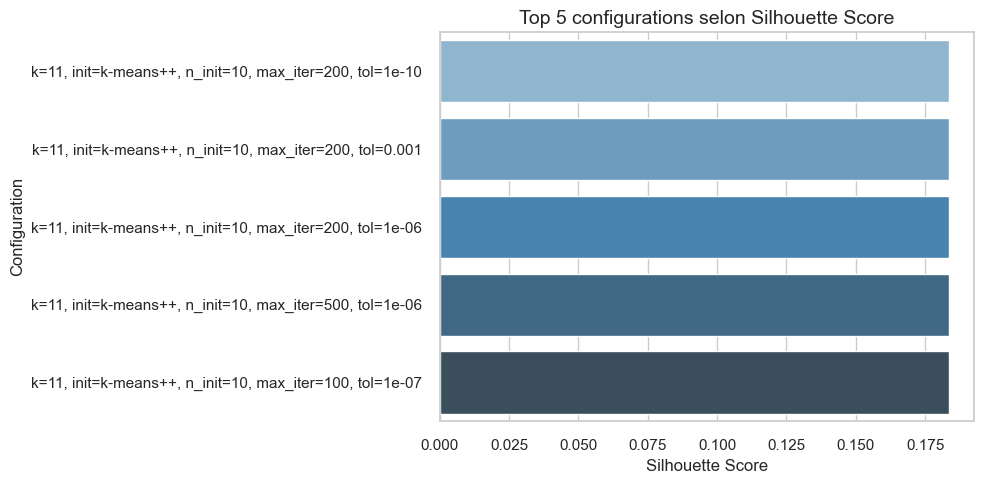

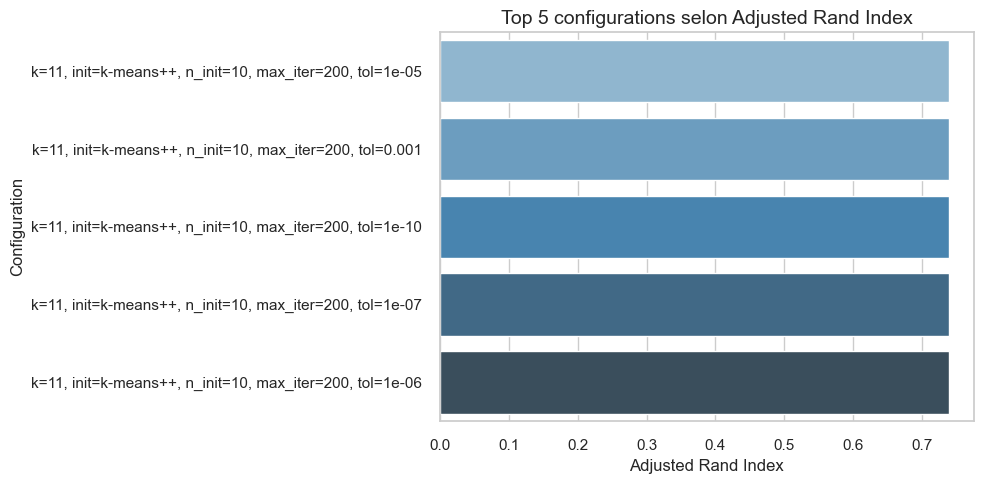

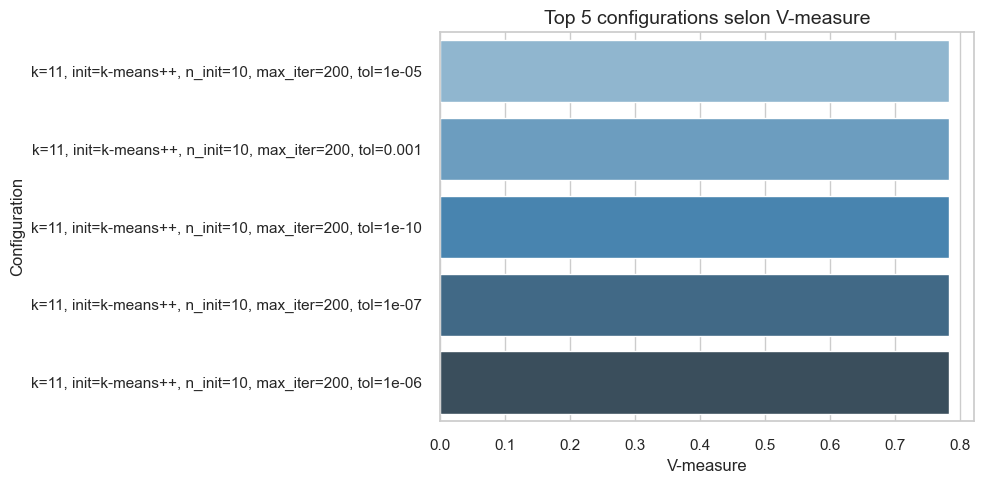

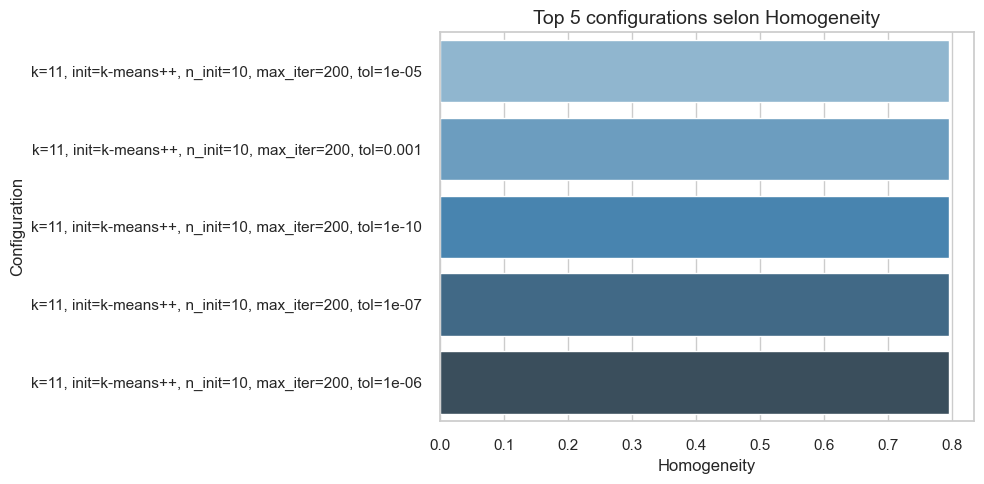

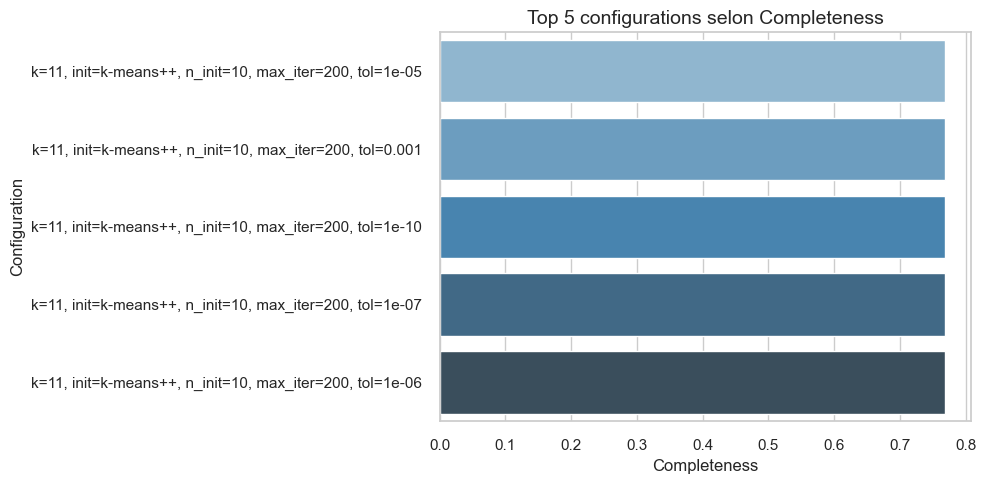

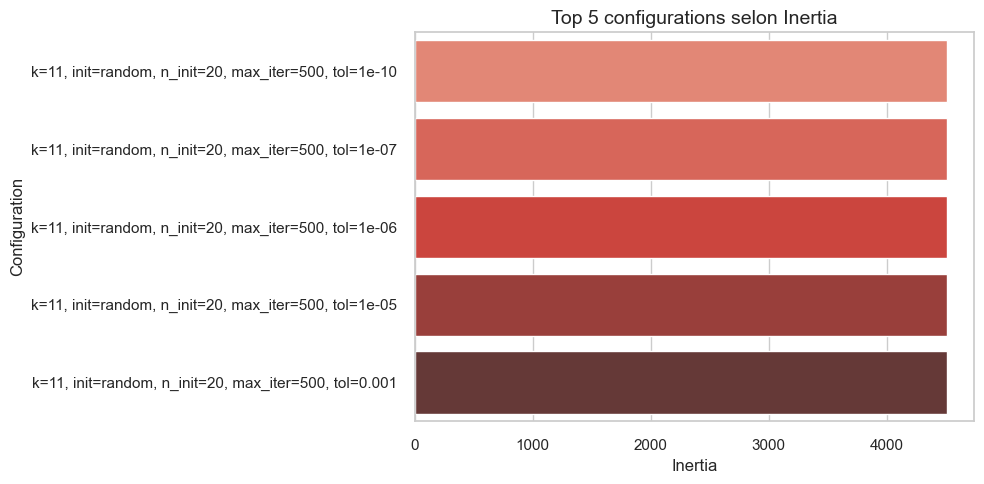

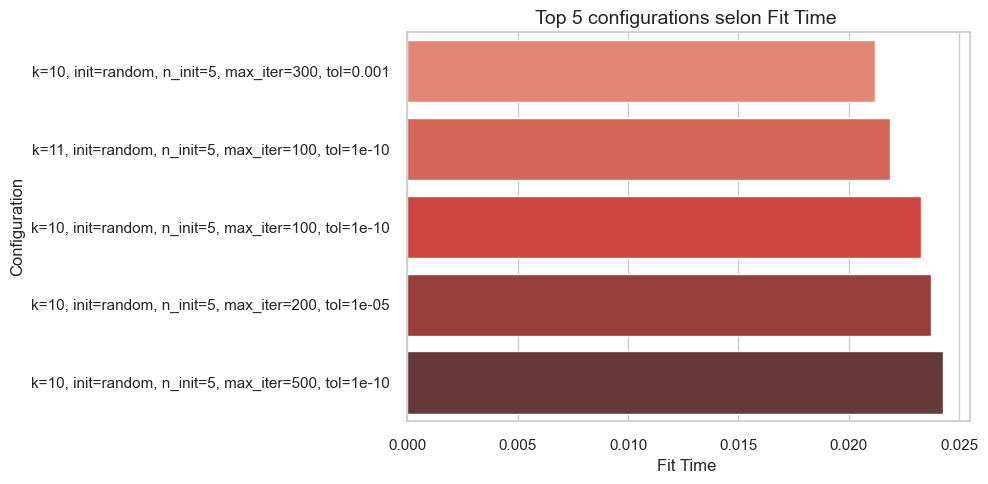

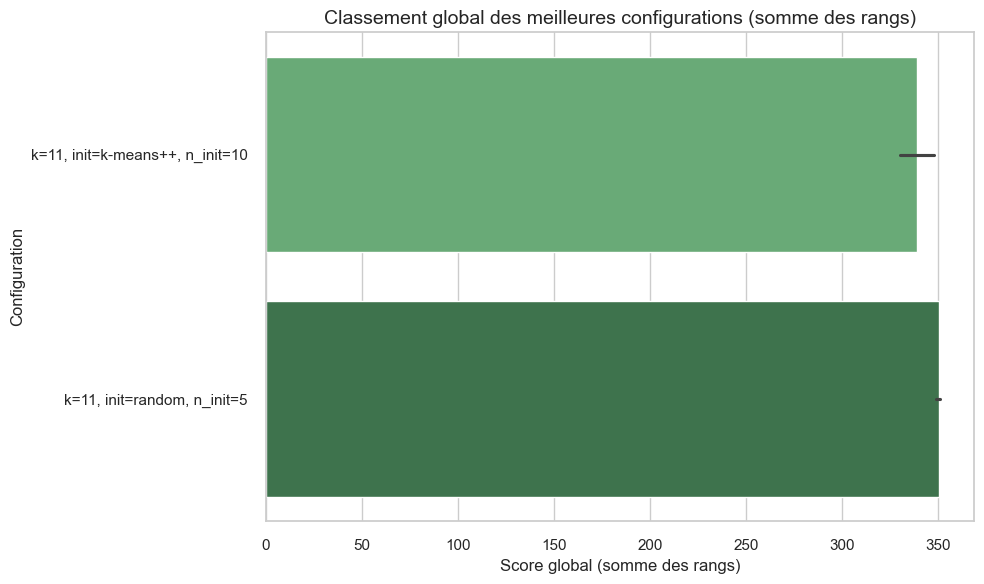

In [200]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
#results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
results_df = pd.json_normalize(df["results"])

params_df = df["params"].apply(pd.Series)


def plot_top_configs(metric, label, ascending):
    sorted_df = df_viz.sort_values(by=metric, ascending=ascending).head(top_n).copy()

    # Construire la config en incluant tous les hyperparamètres
    sorted_df["config"] = sorted_df.apply(
        lambda row: (
            f"k={row['n_clusters']}, init={row['init']}, "
            f"n_init={row['n_init']}, max_iter={row['max_iter']}, tol={row['tol']}"
        ),
        axis=1
    )

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=sorted_df.sort_values(metric, ascending=ascending),
        y="config",
        hue="config", 
        x=metric,
        order=sorted_df.sort_values(metric, ascending=ascending)["config"],
        dodge=False,
        palette="Reds_d" if ascending else "Blues_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()


for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [201]:
#Top 5 global
print("Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)")
# On récupère les indices des top 5 
top5_indices = ranks_sorted.head(top_n).index

top5_global_configs = df_viz.loc[top5_indices].copy()

top5_global_configs["total_rank"] = ranks_sorted.head(top_n)["total_rank"].values

top5_global_configs = top5_global_configs.sort_values("total_rank").reset_index(drop=True)
top5_global_configs



Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)


,init,max_iter,n_clusters,n_init,tol,name,fit_time,inertia,homogeneity,completeness,v_measure,ari,silhouette,total_rank
0,k-means++,100,10,5,1.000000e-03,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.055519,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,330.0
1,k-means++,100,10,5,1.000000e-05,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.053348,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,348.0
2,k-means++,100,10,5,1.000000e-06,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.041848,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,349.0
3,k-means++,100,10,5,1.000000e-07,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.061279,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,351.0
4,k-means++,100,10,5,1.000000e-10,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.049198,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,351.0


In [202]:
# on s'en servira lors de la comparaison avec ou sans pca
best_silhouette_config = df_viz.loc[df_viz["silhouette"].idxmax()]
best_silhouette_config

init                                                    k-means++
max_iter                                                      100
n_clusters                                                     11
n_init                                                         10
tol                                                         0.001
name            k=11, init=k-means++, n_init=10, max_iter=100,...
fit_time                                                 0.148179
inertia                                               4516.827829
homogeneity                                              0.794928
completeness                                             0.769104
v_measure                                                0.781803
ari                                                      0.738101
silhouette                                               0.183457
Name: 25, dtype: object

In [203]:
best_config = top5_global_configs.iloc[0] 
best_config

init                                                    k-means++
max_iter                                                      100
n_clusters                                                     10
n_init                                                          5
tol                                                         0.001
name            k=10, init=k-means++, n_init=5, max_iter=100, ...
fit_time                                                 0.055519
inertia                                               4647.124279
homogeneity                                              0.741941
completeness                                             0.750767
v_measure                                                0.746328
ari                                                      0.671904
silhouette                                               0.182568
total_rank                                                  330.0
Name: 0, dtype: object

Si on accorde le même poids à toutes les métriques, on obtient des clusters avec un score de silhouette de 0.182566, ce qui est plutôt  tres faible.les groupes formés ne sont pas  bien séparés et  certains points pourraient être mal placés, ce qui entraîne un chevauchement entre les clusters.

Même si la séparation spatiale n’est pas parfaite, la structure globale des groupes fait du sens et correspond assez bien aux vraies classes. 
malgré cela, le score ari de 0.67 montre que la structure des clusters est assez cohérente avec les classes réelles, ce qui signifie que le regroupement est pertinent, même si spatialement il manque un peu de précision
le score de v-measure  indique que l'homogénéité et la complétude sont bonnes, ce qui signifie que les clusters contiennent des points ayant des caractéristiques similaires et regroupent correctement les éléments d'une même classe
l'homogénéité et la complétude, toutes deux élevé, renforcent cette idée en démontrant que chaque cluster est bien défini et que les données proches en termes de caractéristiques sont bien regroupées .l'inertie, montre que la dispersion des points autour des centres de clusters est modérée, ce qui peut expliquer pourquoi la séparation n'est pas parfaite. une inertie plus basse pourrait indiquer des groupes plus denses et mieux structurés.

globalement, même si le score de silhouette suggère que la séparation entre les clusters pourrait être améliorée, les autres métriques indiquent une bonne cohérence interne et une structuration efficace des données. Pour aller plus loins nous pouvons revenir sur le nombre de cluster que nous avons volontier fixé entre 10 et 11 pour cause de connaissance sur le dataset.

Le silhouette est vraiment faible malgres l'optimisaton



# - Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)

Nous allons refaire l'optimisation mais avec PCA sans chercher à visualiser nos données 

In [204]:
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

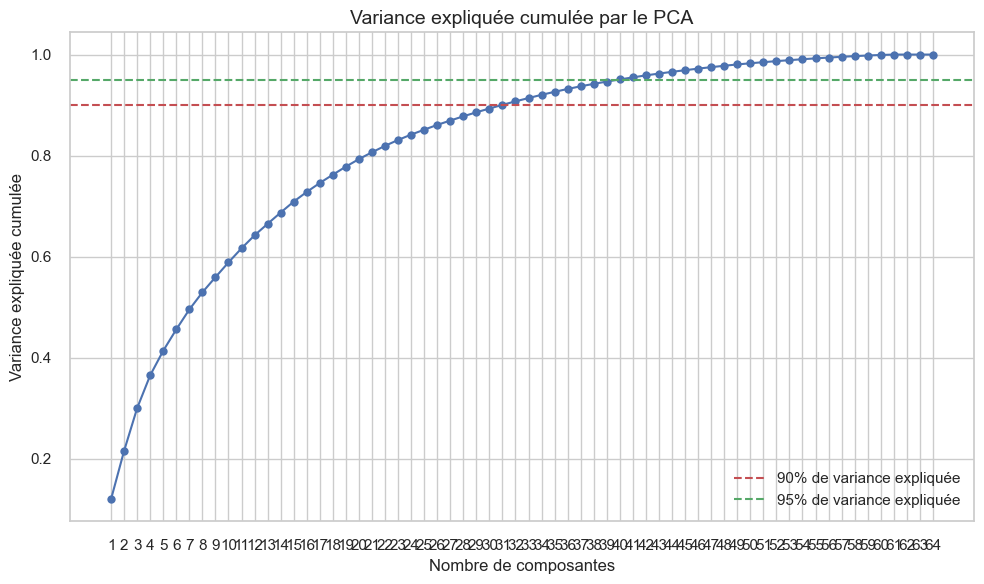

In [205]:
#PCA sans réduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#variance expliquée cumulée
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% de variance expliquée')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% de variance expliquée')
plt.title("Variance expliquée cumulée par le PCA")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [206]:
print(np.argmax(explained_variance >= 0.90) + 1)
n_components=np.argmax(explained_variance >= 0.90) + 1


31


In [207]:
# On refait une nouvelle ACP avec les n_components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


In [208]:

# Standardisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_pca)
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [1,2,5,10,15,20,25],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=221, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=1, max_iter=100, tol=0.001	0.035s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=1, max_iter=100, tol=1e-05	0.017s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=1, max_iter=100, tol=1e-06	0.013s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=1, max_iter=100, tol=1e-07	0.020s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=1, max_iter=100, tol=1e-10	0.010s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=2, max_iter=100, tol=0.001	0.025s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=2, max_iter=100, tol=1e-05	0.049s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=2, max_iter=100, tol=1e-06	0.026s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=2, max_iter=100, tol=1e-07	0.033s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++, n_init=2, max_iter=100, tol=1e-10	0.036s	4648	0.732	0.740	0.736	0.660	0.182
k=10, init=k-means++

In [209]:
#copier_coller

def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)



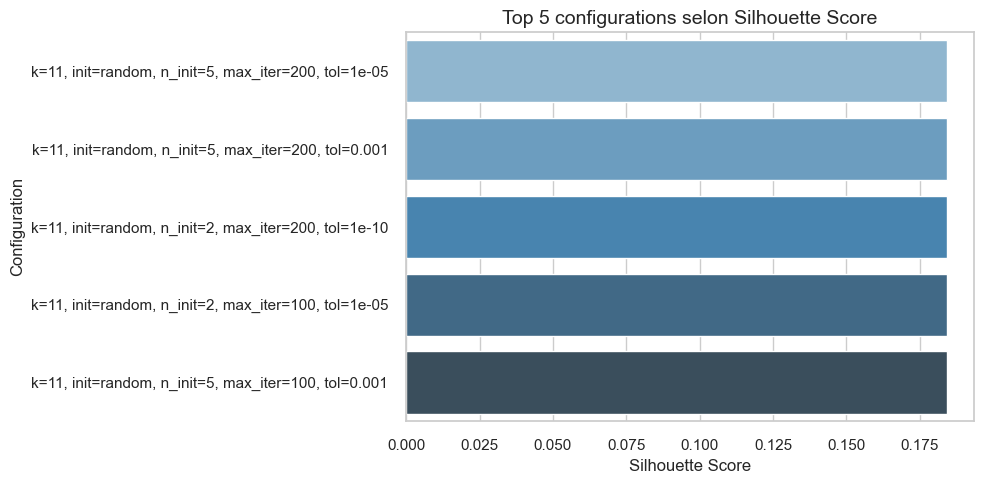

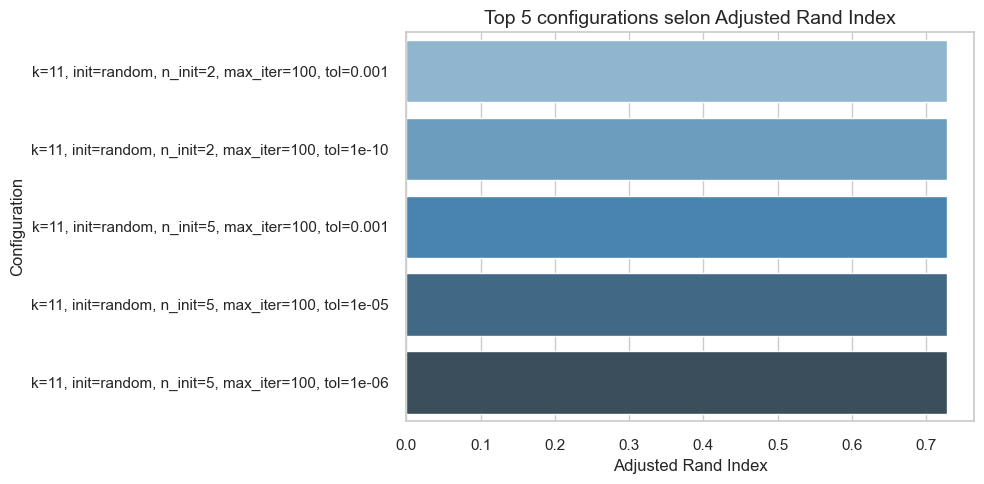

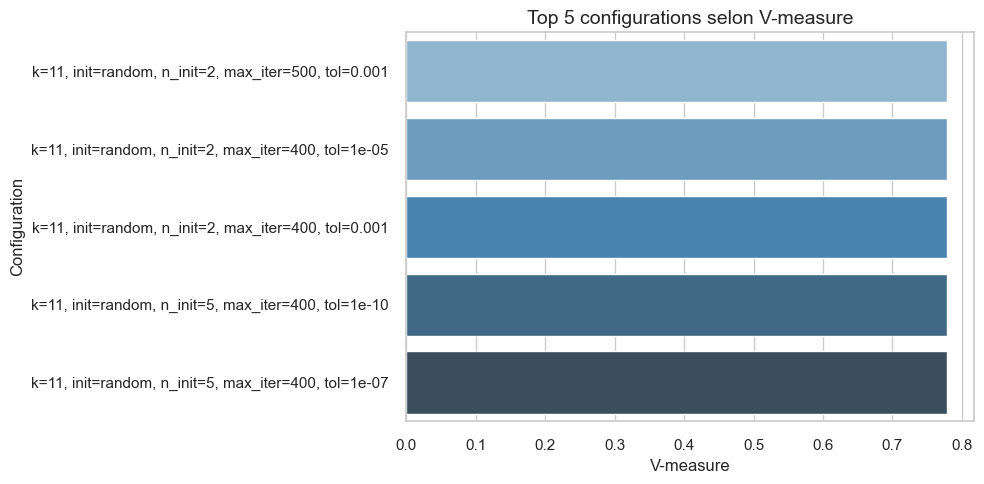

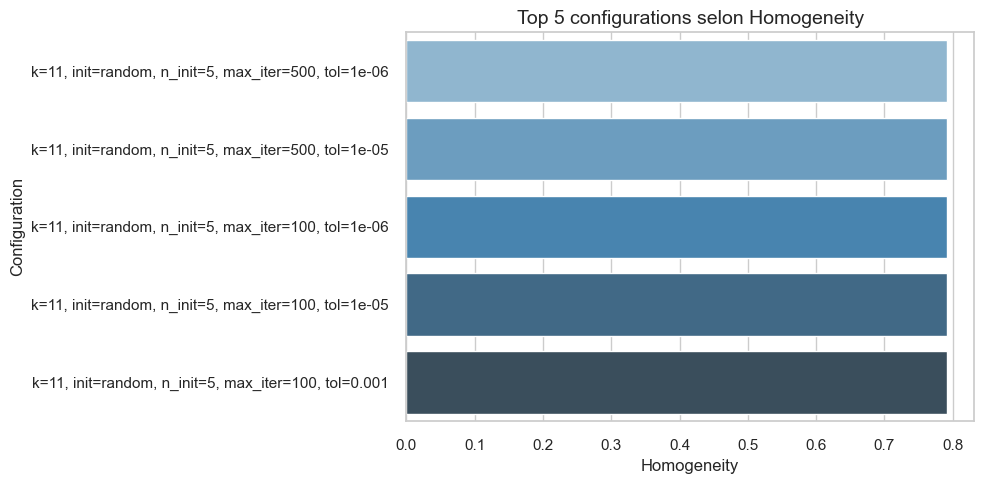

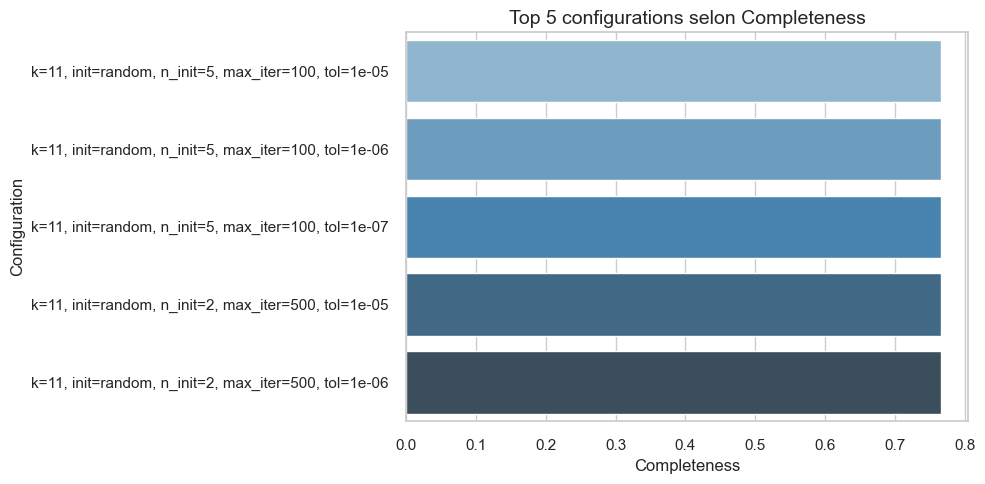

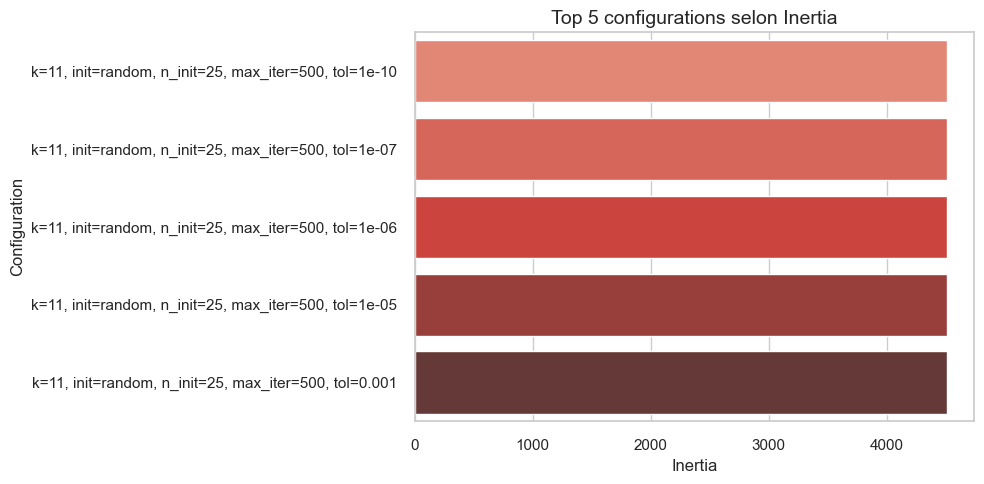

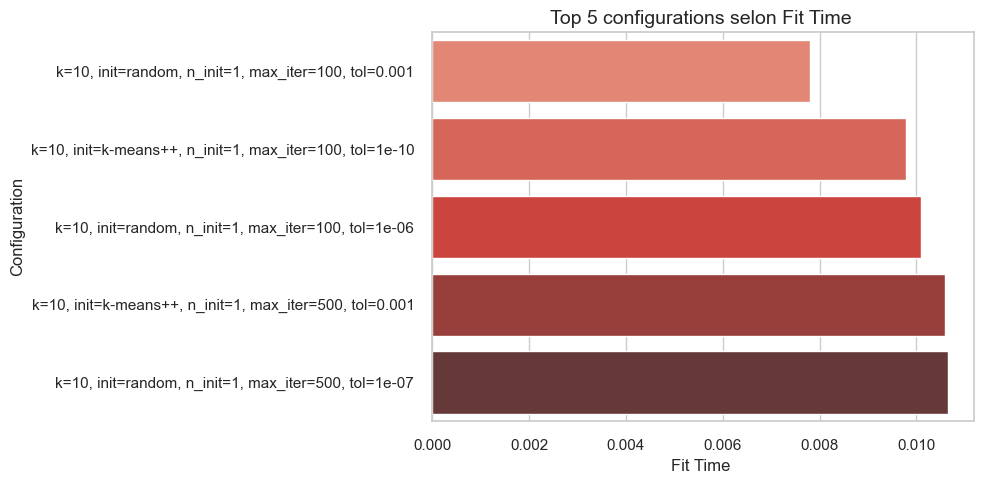

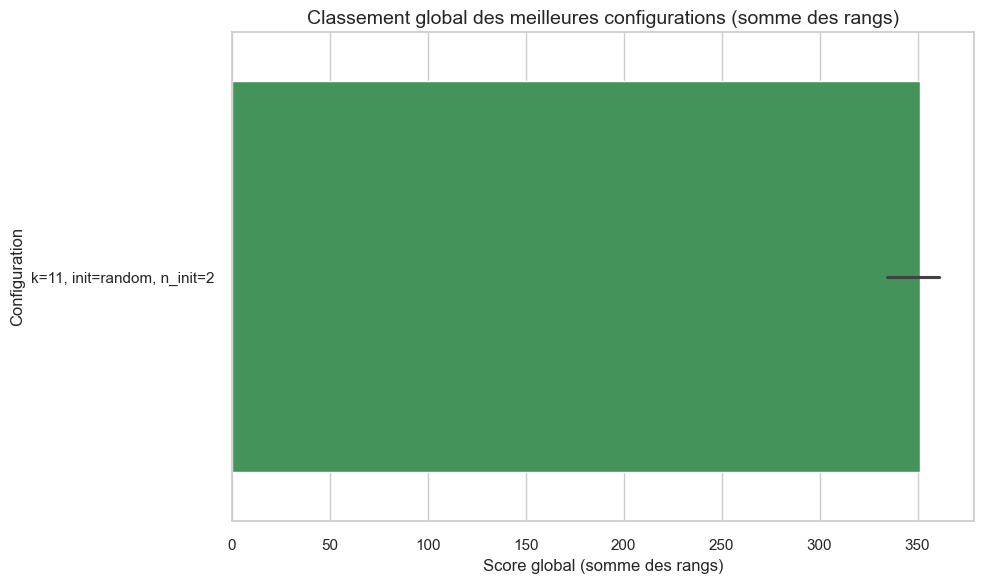

In [210]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
#results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
results_df = pd.json_normalize(df["results"])

params_df = df["params"].apply(pd.Series)


def plot_top_configs(metric, label, ascending):
    sorted_df = df_viz.sort_values(by=metric, ascending=ascending).head(top_n).copy()

    # Construire la config en incluant tous les hyperparamètres
    sorted_df["config"] = sorted_df.apply(
        lambda row: (
            f"k={row['n_clusters']}, init={row['init']}, "
            f"n_init={row['n_init']}, max_iter={row['max_iter']}, tol={row['tol']}"
        ),
        axis=1
    )

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=sorted_df.sort_values(metric, ascending=ascending),
        y="config",
        hue="config", 
        x=metric,
        order=sorted_df.sort_values(metric, ascending=ascending)["config"],
        dodge=False,
        palette="Reds_d" if ascending else "Blues_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()


for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [211]:
#Top 5 global
print("Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)")
# On récupère les indices des top 5 
top5_indices = ranks_sorted.head(top_n).index

top5_global_configs = df_viz.loc[top5_indices].copy()

top5_global_configs["total_rank"] = ranks_sorted.head(top_n)["total_rank"].values

top5_global_configs = top5_global_configs.sort_values("total_rank").reset_index(drop=True)
top5_global_configs



Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)


,init,max_iter,n_clusters,n_init,tol,name,fit_time,inertia,homogeneity,completeness,v_measure,ari,silhouette,total_rank
0,k-means++,100,10,1,1.000000e-03,"k=10, init=k-means++, n_init=1, max_iter=100, ...",0.035100,4648.079106,0.73191,0.74042,0.73614,0.660371,0.182303,318.0
1,k-means++,100,10,1,1.000000e-05,"k=10, init=k-means++, n_init=1, max_iter=100, ...",0.017107,4648.079106,0.73191,0.74042,0.73614,0.660371,0.182303,357.0
2,k-means++,100,10,1,1.000000e-06,"k=10, init=k-means++, n_init=1, max_iter=100, ...",0.012896,4648.079106,0.73191,0.74042,0.73614,0.660371,0.182303,358.0
3,k-means++,100,10,1,1.000000e-07,"k=10, init=k-means++, n_init=1, max_iter=100, ...",0.020145,4648.079106,0.73191,0.74042,0.73614,0.660371,0.182303,361.0
4,k-means++,100,10,1,1.000000e-10,"k=10, init=k-means++, n_init=1, max_iter=100, ...",0.009782,4648.079106,0.73191,0.74042,0.73614,0.660371,0.182303,362.0


In [212]:
best_config_pca = top5_global_configs.iloc[0] 
best_config_pca
# On ne fait plus l'agregation car avec pca on a un silouette score de % ce qui est tres faible

init                                                    k-means++
max_iter                                                      100
n_clusters                                                     10
n_init                                                          1
tol                                                         0.001
name            k=10, init=k-means++, n_init=1, max_iter=100, ...
fit_time                                                   0.0351
inertia                                               4648.079106
homogeneity                                               0.73191
completeness                                              0.74042
v_measure                                                 0.73614
ari                                                      0.660371
silhouette                                               0.182303
total_rank                                                  318.0
Name: 0, dtype: object

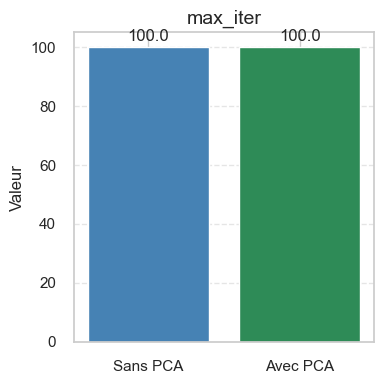

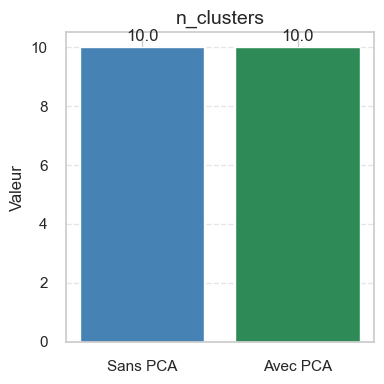

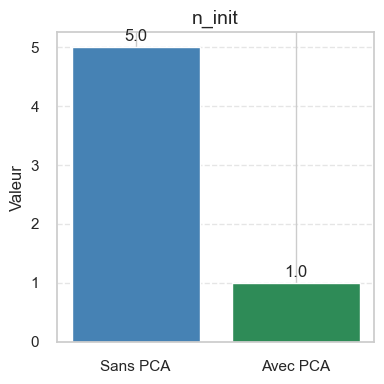

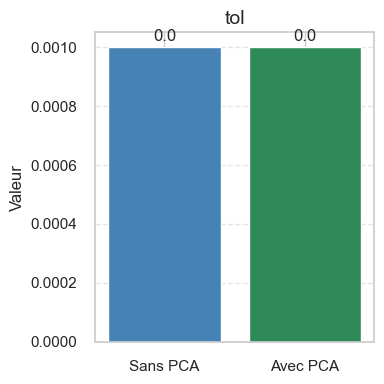

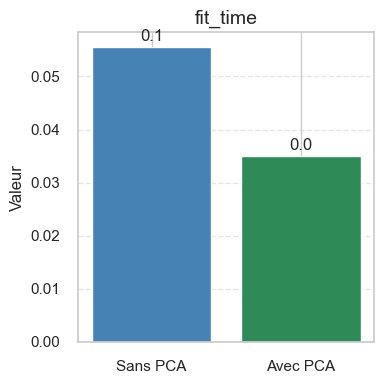

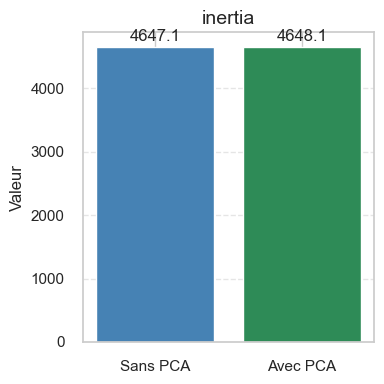

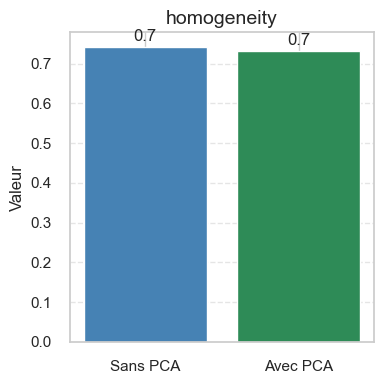

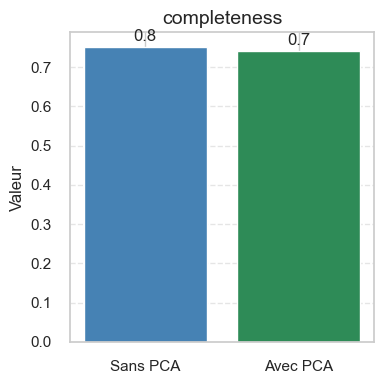

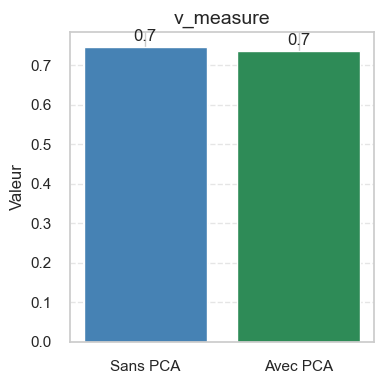

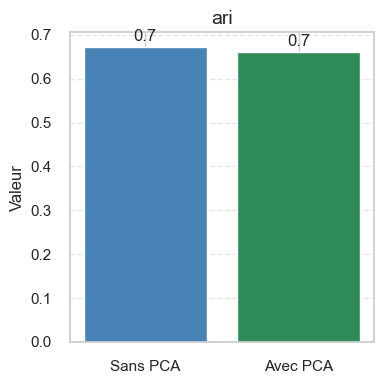

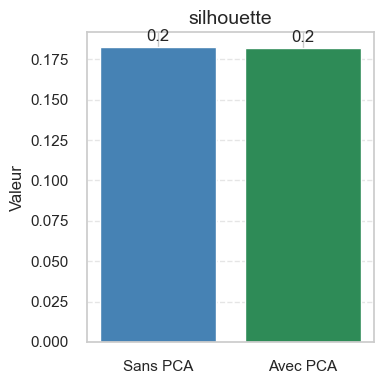

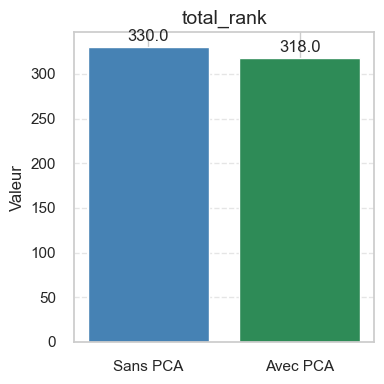

In [213]:
df = pd.DataFrame({"Sans PCA": best_config, "Avec PCA": best_config_pca})
df_numeric = df.drop(index=["init", "name"])
 # supprimer le champ non numérique

#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans PCA", "Avec PCA"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Les deux approches sont sensiblement equivalente mais on perd en silhouette score; On va changer d'approche on va prendre le best config en silhouette score.

In [214]:
best_silhouette_config_pca = df_viz.loc[df_viz["silhouette"].idxmax()]
best_silhouette_config_pca


init                                                       random
max_iter                                                      100
n_clusters                                                     11
n_init                                                          2
tol                                                       0.00001
name            k=11, init=random, n_init=2, max_iter=100, tol...
fit_time                                                 0.027749
inertia                                                4521.12759
homogeneity                                              0.791615
completeness                                             0.766133
v_measure                                                0.778666
ari                                                       0.72789
silhouette                                               0.184253
Name: 391, dtype: object

In [215]:
best_silhouette_config

init                                                    k-means++
max_iter                                                      100
n_clusters                                                     11
n_init                                                         10
tol                                                         0.001
name            k=11, init=k-means++, n_init=10, max_iter=100,...
fit_time                                                 0.148179
inertia                                               4516.827829
homogeneity                                              0.794928
completeness                                             0.769104
v_measure                                                0.781803
ari                                                      0.738101
silhouette                                               0.183457
Name: 25, dtype: object

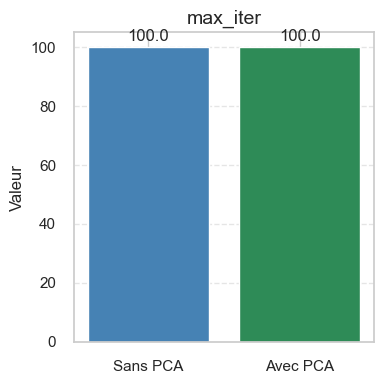

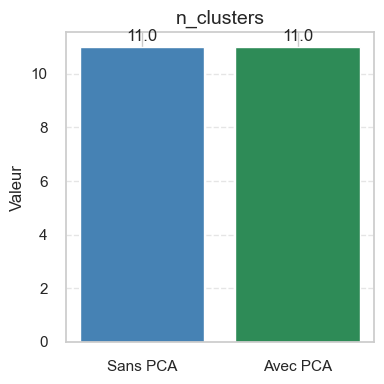

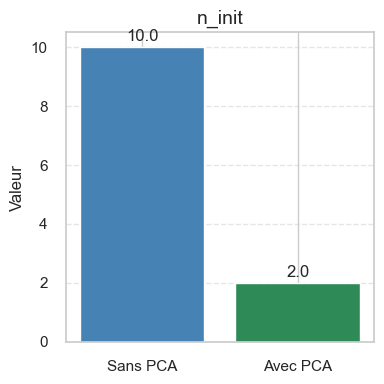

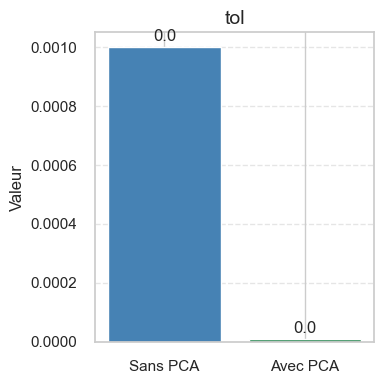

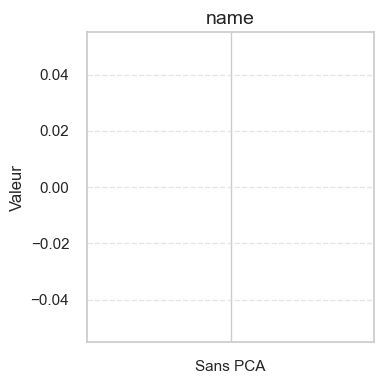

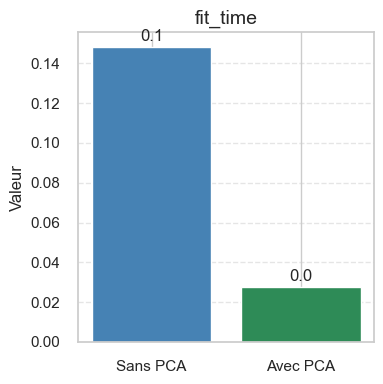

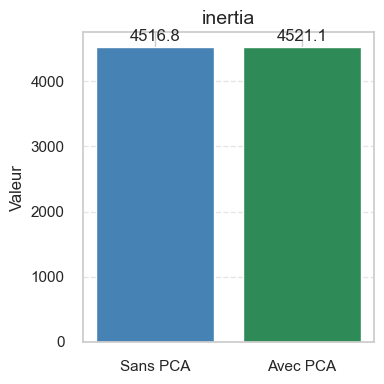

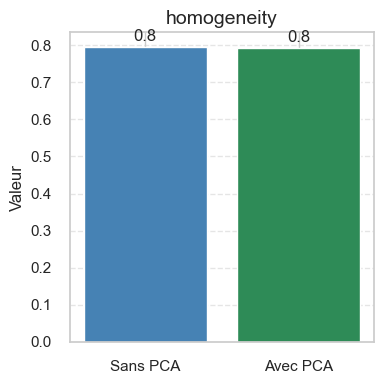

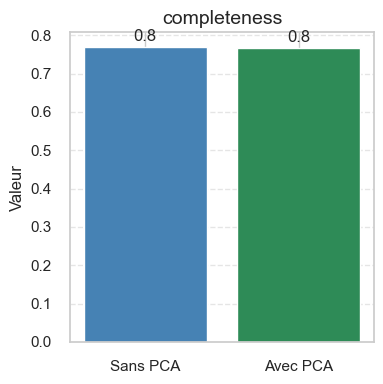

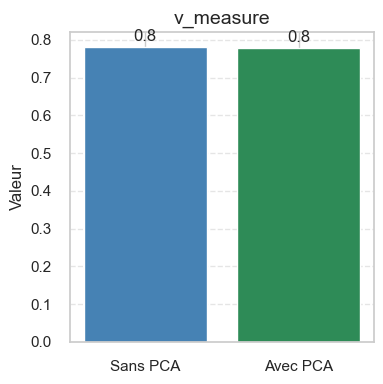

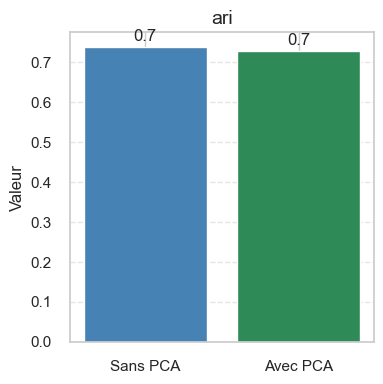

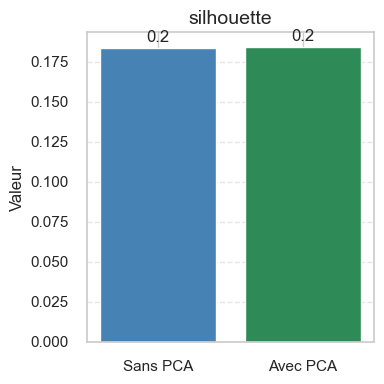

In [216]:
df = pd.DataFrame({"Sans PCA": best_silhouette_config, "Avec PCA": best_silhouette_config_pca})
df_numeric = df.drop(index="init")  # supprimer le champ non numérique
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')  # Convertir


#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans PCA", "Avec PCA"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Globalement les deux methodes sont presque equivalente
Le probleme viens peut-être de la méthode k-mean en elle même.
le seul point positif du pca c'est le temps d'entrainement

# Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)

Avec standardisation on peut tester d'autres metriques, on pourra ecrire une fonction qui prend la methode de standardisation en argument
En attendant nous restons avec ce qui a deja été fait, examinons à present le cas de non standardisation
Un meilleur travail consistait à anticiper les questions  en creant des fonctions avec pleins de parametres afin d'eviter de copier coller du code mais bon ...


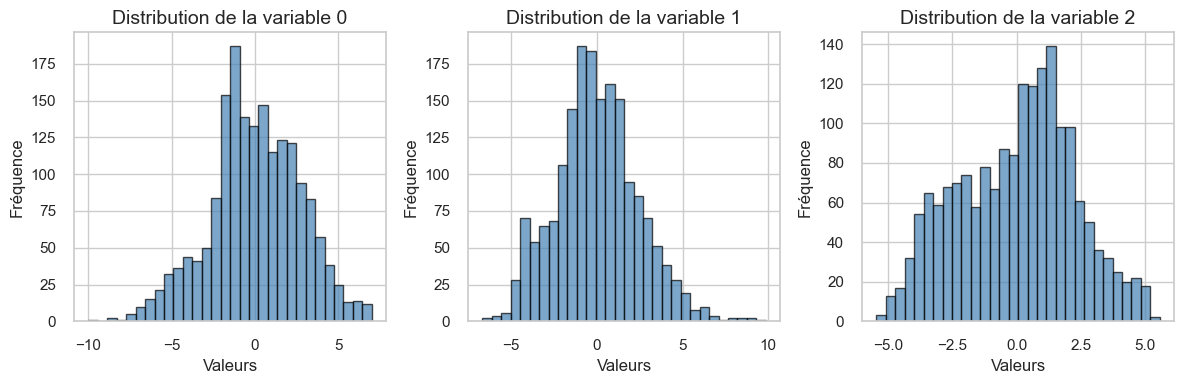

In [217]:

# Sélectionner quelques variables de X_scaled
variables = [0, 1, 2]  

plt.figure(figsize=(12, 4))

for i, var in enumerate(variables, 1):
    plt.subplot(1, len(variables), i)
    plt.hist(X_pca[:, var], bins=30, alpha=0.7, color="steelblue", edgecolor="black")
    plt.title(f"Distribution de la variable {var}")
    plt.xlabel("Valeurs")
    plt.ylabel("Fréquence")
    
plt.tight_layout()
plt.show()

> clairement  pas de standardisation

In [218]:

# Standardisation= False
X_scaled = X_pca  #  sans standardisation
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [5,10,15,20],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=221, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=5, max_iter=100, tol=0.001	0.149s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-05	0.133s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-06	0.140s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-07	0.125s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-10	0.128s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=0.001	0.237s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-05	0.212s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-06	0.232s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-07	0.160s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-10	0.144s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-me

In [219]:
#copier_coller

def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)



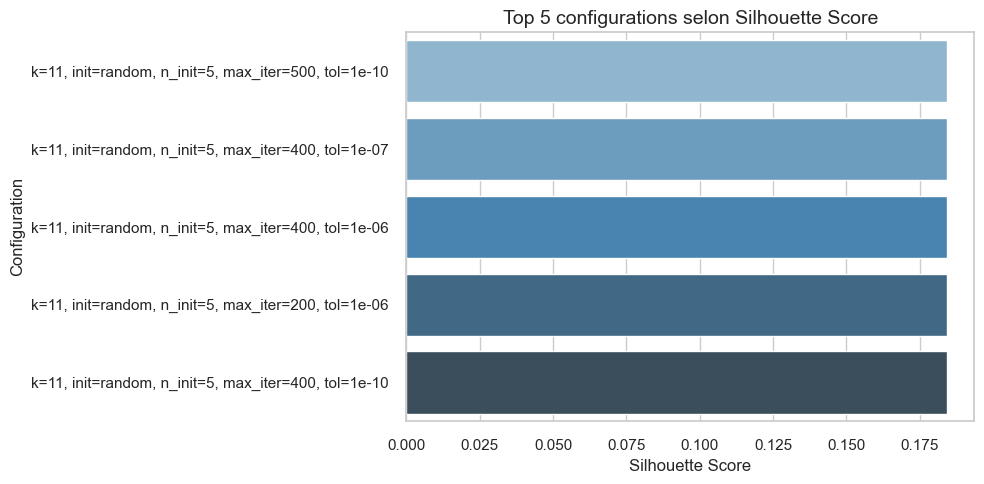

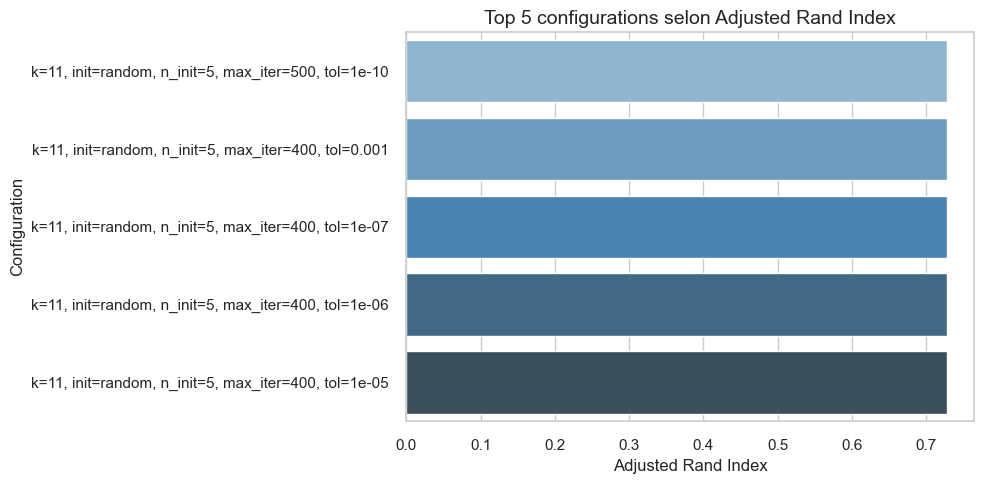

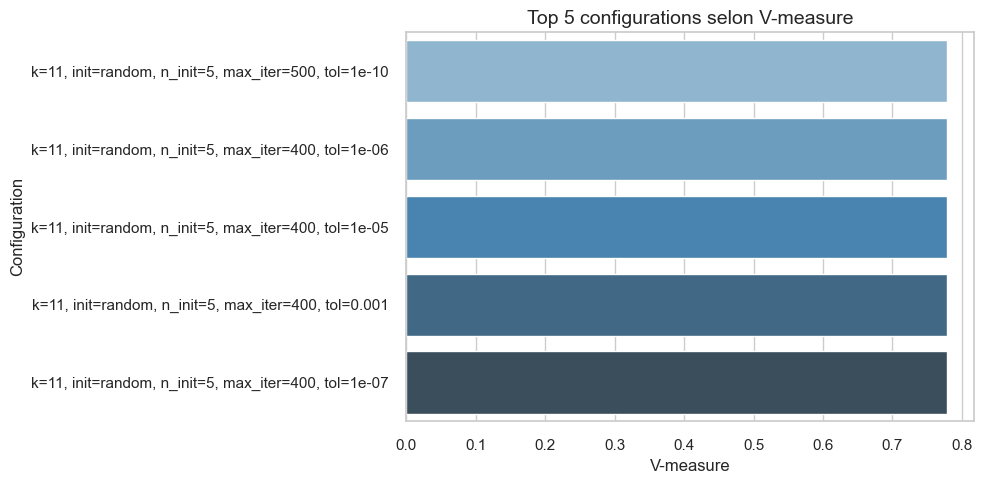

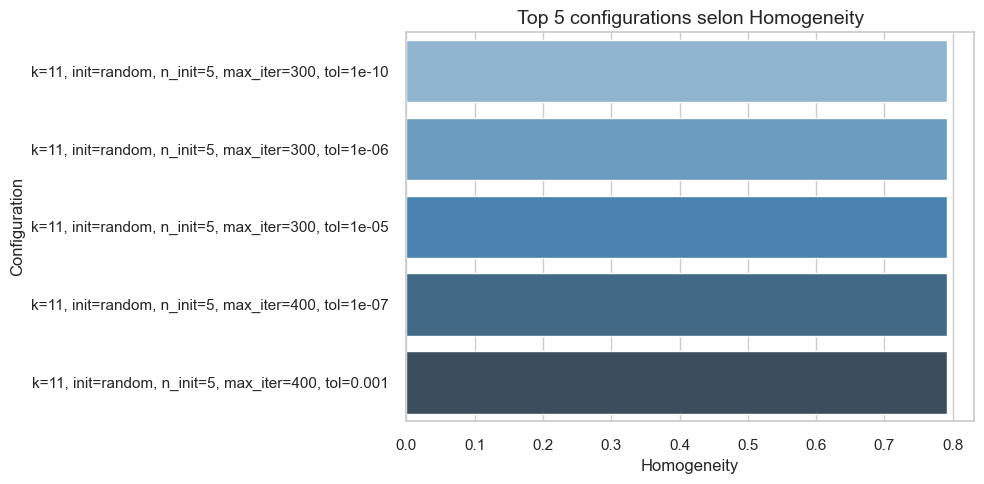

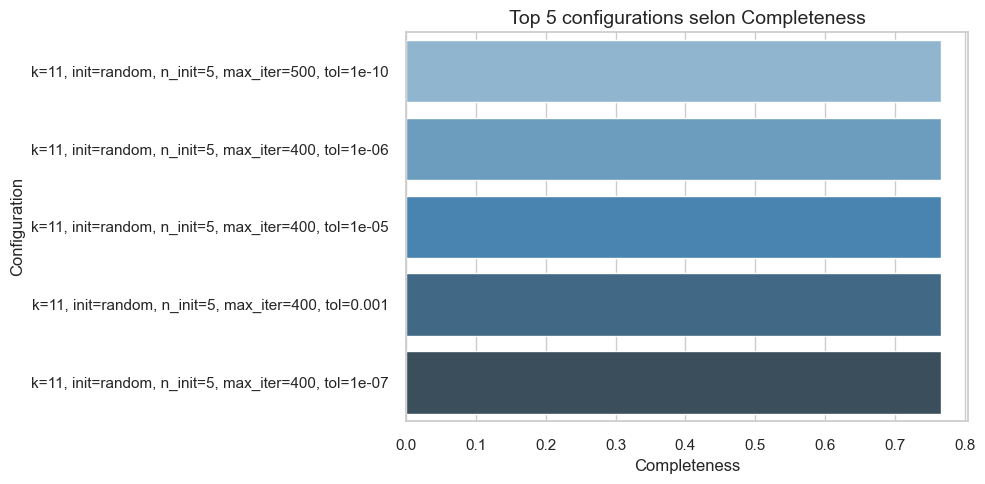

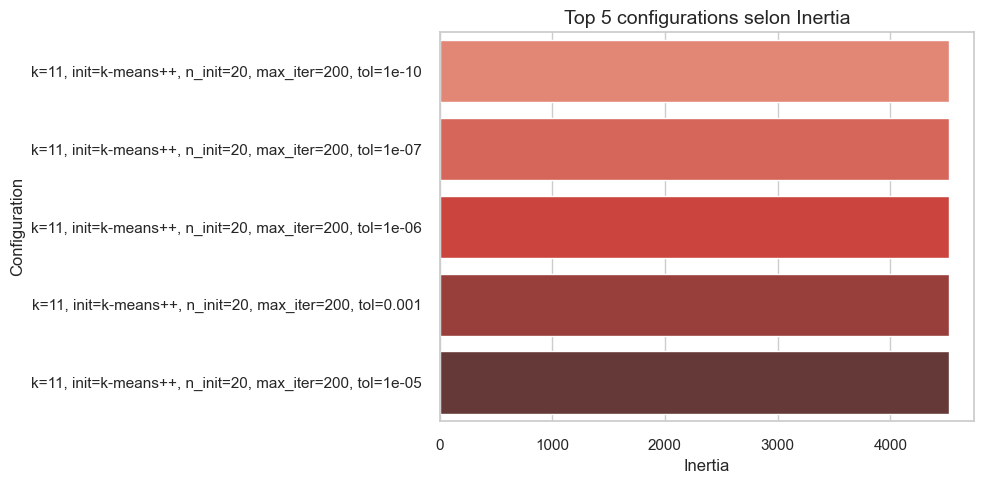

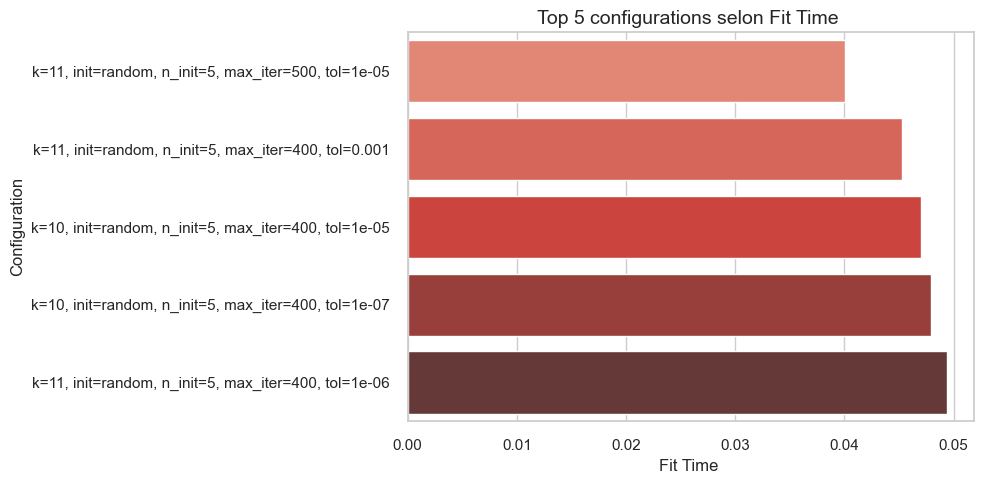

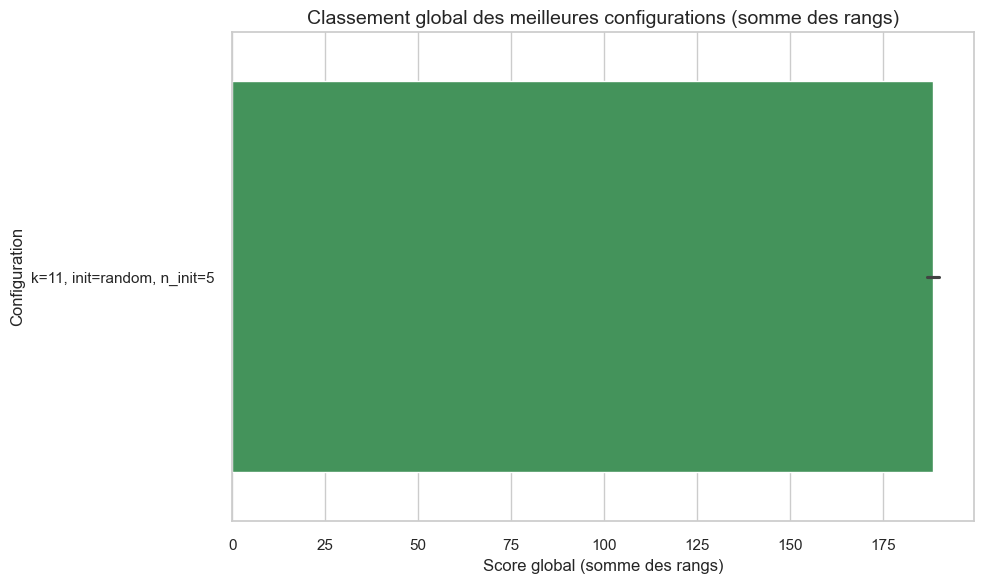

In [220]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
#results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
results_df = pd.json_normalize(df["results"])

params_df = df["params"].apply(pd.Series)


def plot_top_configs(metric, label, ascending):
    sorted_df = df_viz.sort_values(by=metric, ascending=ascending).head(top_n).copy()

    # Construire la config en incluant tous les hyperparamètres
    sorted_df["config"] = sorted_df.apply(
        lambda row: (
            f"k={row['n_clusters']}, init={row['init']}, "
            f"n_init={row['n_init']}, max_iter={row['max_iter']}, tol={row['tol']}"
        ),
        axis=1
    )

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=sorted_df.sort_values(metric, ascending=ascending),
        y="config",
        hue="config", 
        x=metric,
        order=sorted_df.sort_values(metric, ascending=ascending)["config"],
        dodge=False,
        palette="Reds_d" if ascending else "Blues_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()


for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [221]:
best_silhouette_config_no_standard = df_viz.loc[df_viz["silhouette"].idxmax()]
best_silhouette_config_no_standard


init                                                       random
max_iter                                                      100
n_clusters                                                     11
n_init                                                          5
tol                                                       0.00001
name            k=11, init=random, n_init=5, max_iter=100, tol...
fit_time                                                 0.092611
inertia                                                4521.12759
homogeneity                                              0.791615
completeness                                             0.766133
v_measure                                                0.778666
ari                                                       0.72789
silhouette                                               0.184253
Name: 221, dtype: object

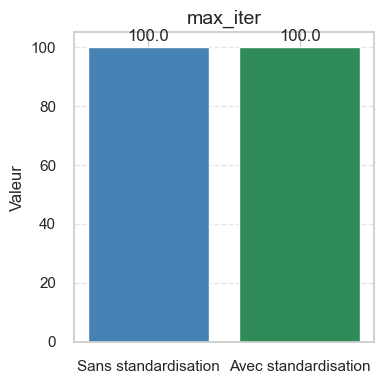

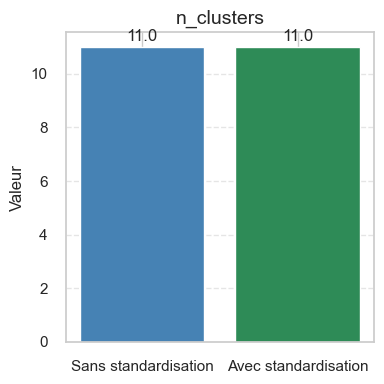

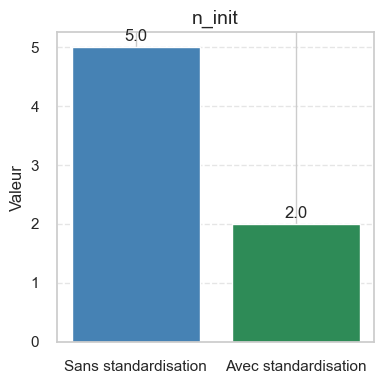

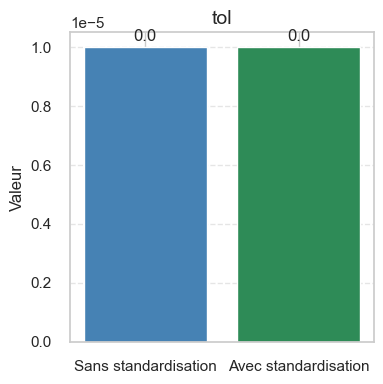

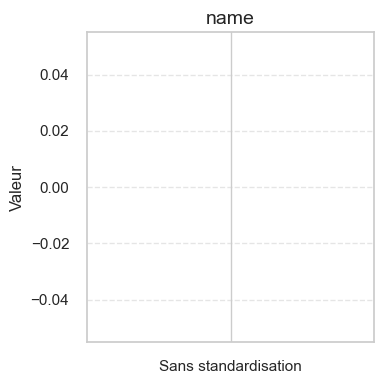

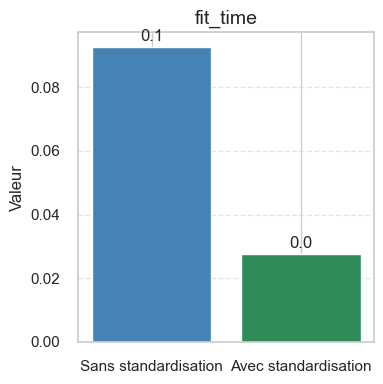

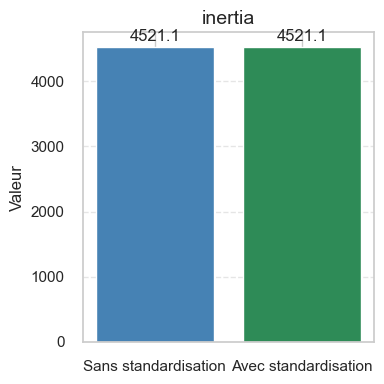

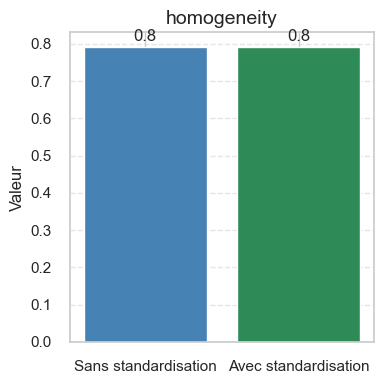

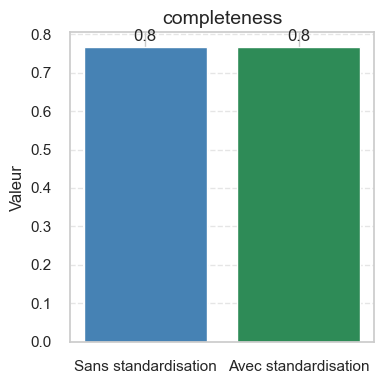

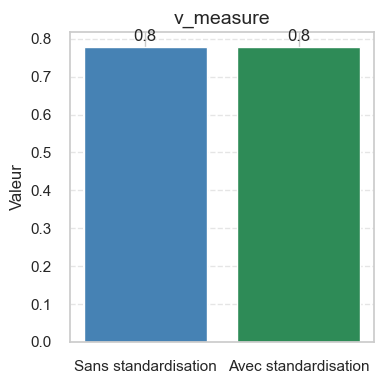

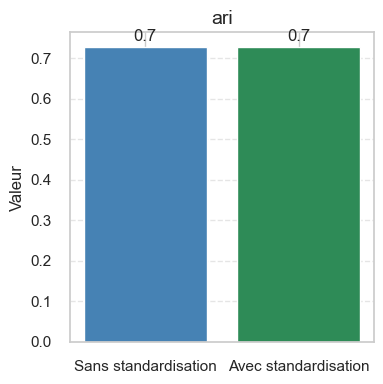

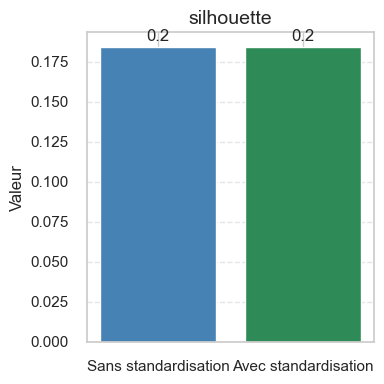

In [222]:
df = pd.DataFrame({"Sans standardisation": best_silhouette_config_no_standard, "Avec standardisation": best_silhouette_config_pca})
df_numeric = df.drop(index="init")  # supprimer le champ non numérique
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')  # Convertir


#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans standardisation", "Avec standardisation"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Manifestement elle n'a aucun impacte sur les metriques

# - Faire l'analyse des personnas pour le meilleur modèle

In [223]:
best_silhouette_config_pca

init                                                       random
max_iter                                                      100
n_clusters                                                     11
n_init                                                          2
tol                                                       0.00001
name            k=11, init=random, n_init=2, max_iter=100, tol...
fit_time                                                 0.027749
inertia                                                4521.12759
homogeneity                                              0.791615
completeness                                             0.766133
v_measure                                                0.778666
ari                                                       0.72789
silhouette                                               0.184253
Name: 391, dtype: object

In [224]:
#  le meilleur model et ses labels
best_kmeans = KMeans(
    n_clusters=best_silhouette_config_pca["n_clusters"], 
    init=best_silhouette_config_pca["init"], 
    n_init=best_silhouette_config_pca["n_init"], 
    max_iter=best_silhouette_config_pca["max_iter"], 
    tol=best_silhouette_config_pca["tol"], 
    random_state=221
)
pipeline = make_pipeline(MinMaxScaler(), best_kmeans).fit(X_pca) # super important on prend X_pca a la place de X
labels_clusters= pipeline[-1].labels_


In [225]:
# Les seuls colonnes qui importent c'est label et cluster
data.head()# on reprend notre data initial

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,6
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,5
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,8
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,7


In [226]:
# add du label des clusters
data["cluster_pca"] = labels_clusters  
print(data["cluster"].unique())  
print(data["cluster"].value_counts())  # la répartition des clusters



[6 5 8 0 7 4 2 3 1 9]
cluster
8    227
3    210
2    207
4    185
7    184
1    180
9    174
6    170
0    139
5    121
Name: count, dtype: int64


Le silhouette score est une metrique qui permet de savoir à quel point un point est bien placé dans son cluster.
Chaque observation dans data possède un label cluster_pca, qui lui indique à quel groupe elle appartient.
On va calculer ce score dans chaque cluster afin de savoir à quel quels sont les clusters qui sont bien representé ou pas

In [227]:

# Taille et silhouette score moyenne par cluster

# nombre d'éléments par cluster
summary_size = data.groupby("cluster_pca").size().rename("count")

# calcul des silhouette score pour chaque point
silhouette_scores = metrics.silhouette_samples(
    X_pca, 
    data["cluster_pca"]
)

data["silhouette"] = silhouette_scores

#score de silhouette moyen par cluster
summary_silhouette = (
    data
    .groupby("cluster_pca")["silhouette"]
    .mean()
    .rename("mean_silhouette")
)

cluster_stats = pd.concat([summary_size, summary_silhouette], axis=1)

print(cluster_stats)


             count  mean_silhouette
cluster_pca                        
0               44         0.316780
1              279         0.117531
2              197         0.207966
3               26         0.111581
4              180         0.353834
5              177         0.013214
6                7         0.494660
7              130         0.086222
8              148         0.121254
9              180         0.212709
10             429         0.140720


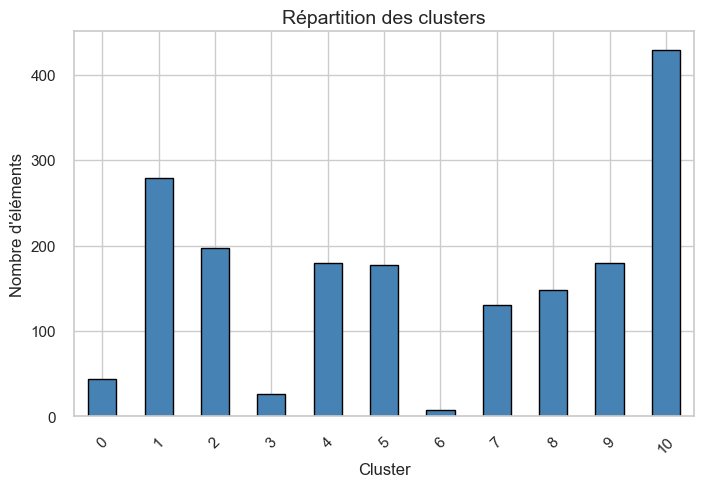

In [228]:
# Histogramme de la taille des clusters
plt.figure(figsize=(8, 5))
cluster_stats["count"].plot(kind="bar", color="steelblue", edgecolor="black")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'éléments")
plt.title("Répartition des clusters")
plt.xticks(rotation=45)
plt.show() # on a un clusters que le modéle a trop donnée en importance

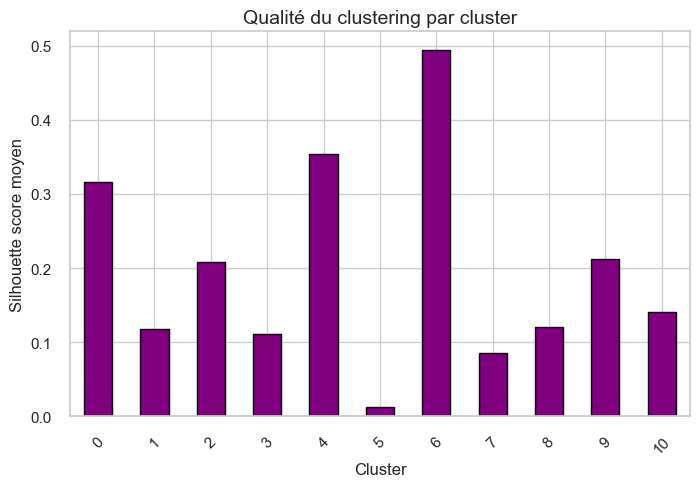

In [229]:
#Moyenne du silhouette score par cluster
plt.figure(figsize=(8, 5))
cluster_stats["mean_silhouette"].plot(kind="bar", color="purple", edgecolor="black")
plt.xlabel("Cluster")
plt.ylabel("Silhouette score moyen")
plt.title("Qualité du clustering par cluster")
plt.xticks(rotation=45)
plt.show() # les clusters 1 0 4 et 7  intersectent d'autres clusters

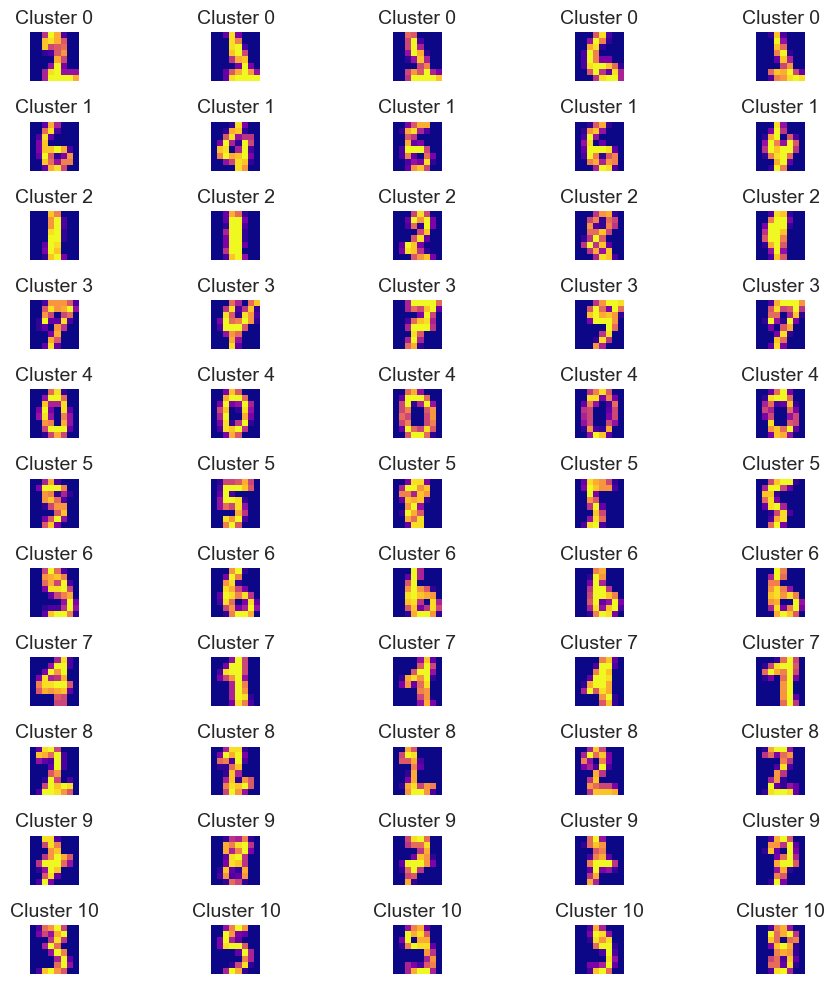

In [230]:

n_images = 5

fig, axes = plt.subplots(data["cluster_pca"].nunique(), n_images, figsize=(10, 10))

for i, cluster_id in enumerate(sorted(data["cluster_pca"].unique())):
    # Sélectionner aléatoirement 5 images du cluster
    sample_images = data[data["cluster_pca"] == cluster_id].sample(n_images, random_state=42).index

    for j, img_index in enumerate(sample_images):
        axes[i, j].imshow(X[img_index].reshape(8, 8), cmap="plasma")  
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()

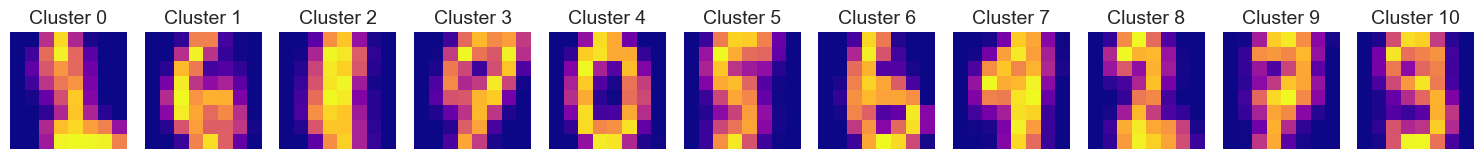

In [231]:
#  les images moyennes de chaque cluster

fig, axes = plt.subplots(1, data["cluster_pca"].nunique(), figsize=(15,18)) 

for i, cluster_id in enumerate(sorted(data["cluster_pca"].unique())):
    mean_image = X[data["cluster_pca"] == cluster_id].mean(axis=0)

    axes[i].imshow(mean_image.reshape(8, 8), cmap="plasma") 
    axes[i].axis("off")
    axes[i].set_title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()

In [232]:

cluster_label_counts = pd.crosstab(data["cluster_pca"], data["label"])
cluster_label_counts


label,0,1,2,3,4,5,6,7,8,9
cluster_pca,,,,,,,,,,
0,0,24,18,1,0,0,1,0,0,0
1,3,0,0,0,105,2,166,0,3,0
2,0,102,7,1,23,1,7,1,55,0
3,0,0,0,0,7,0,0,18,0,1
4,175,0,3,0,1,0,1,0,0,0
5,0,1,4,10,4,102,0,3,45,8
6,0,0,0,0,0,0,6,0,0,1
7,0,52,1,0,37,6,0,3,10,21
8,0,3,142,0,0,0,0,0,3,0


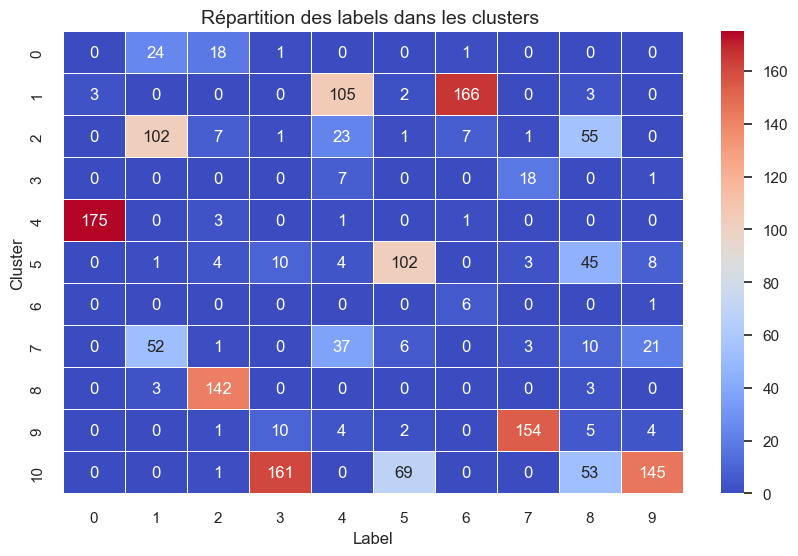

In [233]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_label_counts, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.xlabel("Label")
plt.ylabel("Cluster")
plt.title("Répartition des labels dans les clusters ")
plt.show()

Comme mentionnée, nous avons retenu 11 clusters.

notre modele confond beaucoup les chiffres 3 et 9 il les met tous dans le cluster 10
le cluster 0 semble être le cluster de trop il serais intessant de savoir pourquoi les 1 du cluster 0 ne sont pas dans le cluster 2 qui semble etre leur bonne place.

Ensuite, le silhouette score moyen par cluster évalue la cohésion et la séparation des groupes. Un score élevé indique un bon regroupement, tandis qu’un score faible traduit un chevauchement . Le cluster 6 affiche le meilleur score (0.36), ce qui correspond bien aux observations de la heatmap : il a 2  label pour 7 images  à croire qu'elle ne sert à rien. Les clusters 8, 9,0, et 4 présentent également des scores acceptables (>0.2), indiquant une segmentation correcte. À l’inverse, les clusters 1,5 et 7 ont des scores beaucoup plus bas (0.01 à 0.13), ce qui suggère un mauvais regroupement ou une séparation inefficace entre certaines classes.

dans le cluster 0 les label 1 et 2 sont les plus present .
le cluster 2  a du mal a distinguer les chiffres 1 4 et 8
Comme on a fait une ACP il nous est impossible de reconstituer les images à partir des composantes ACP ce qui fait que même si on peut aisement les individus qui posent probleme on ne peut pas totalement assigner leur mauvais classement uniquement à leur forme atypique au seuil de leur label, peut être que c'est la parte d'information due à l'ACP qui est la source de ces mauvais classement.

Analyser quelle variable influence un cluster ou identifier les caractéristiques les plus déterminantes n’a pas de sens ici, car les colonnes représentent des valeurs de pixels (  des données brutes d’image sans signification directe en termes de classification). De plus, comme nous avons appliqué un PCA, les dimensions ont été transformées, les pixels individuels ne sont plus directement interprétables.

Dans ce contexte, plutôt que d’examiner l’impact de chaque variable, une approche plus pertinente serait de visualiser les images moyennes de chaque cluster et d’analyser leur répartition statistique pour détecter des formes ou motifs distinctifs.  C'est ce qui justifie notre approche


# Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)

In [234]:

tsne = TSNE(n_components=2, random_state=221, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca)


df_vis = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'cluster': labels_clusters        # les labels issus de notre meilleur modele
})




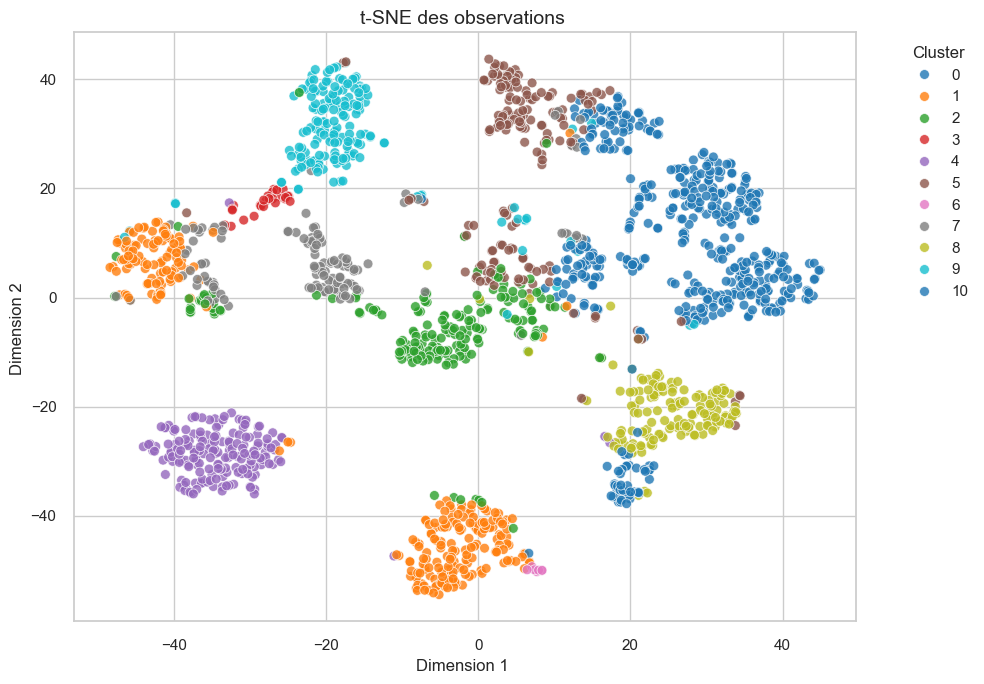

In [235]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_vis,
    x='TSNE1', y='TSNE2',
    hue='cluster',
    palette='tab10',
    legend='full',
    s=50,
    alpha=0.8
)
plt.title("t-SNE des observations ")
plt.xlabel("Dimension 1 ")
plt.ylabel("Dimension 2 ")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [236]:
# Ajout du score de silhouette 
sil_scores = metrics.silhouette_samples(X_pca, labels_clusters)

df_vis['silhouette'] = sil_scores


In [237]:
cluster_stats = df_vis.groupby('cluster').agg(
    size=('cluster', 'size'),
    mean_silhouette=('silhouette', 'mean')
).sort_index()

print(cluster_stats)


         size  mean_silhouette
cluster                       
0          44         0.316780
1         279         0.117531
2         197         0.207966
3          26         0.111581
4         180         0.353834
5         177         0.013214
6           7         0.494660
7         130         0.086222
8         148         0.121254
9         180         0.212709
10        429         0.140720


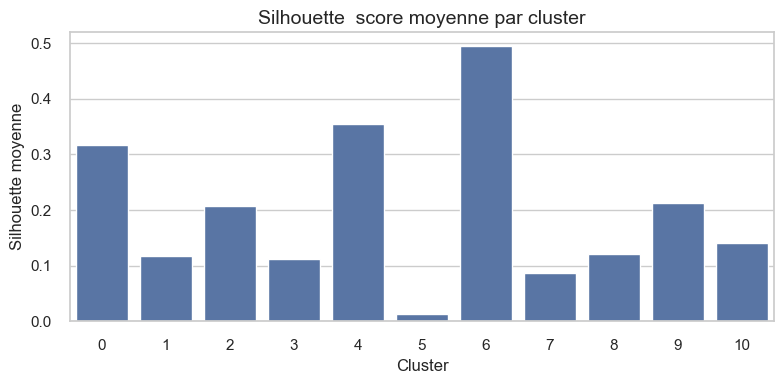

In [238]:
# silhouette moyenne par cluster
plt.figure(figsize=(8, 4))
sns.barplot(
    x=cluster_stats.index.astype(str),
    y='mean_silhouette',
    data=cluster_stats.reset_index(),
    order=cluster_stats.index.astype(str)
)
plt.title("Silhouette  score moyenne par cluster")
plt.xlabel("Cluster")
plt.ylabel("Silhouette moyenne")
plt.tight_layout()
plt.show()



Le cluster 6  a un bon score mais c'est plus due au fait qu'elle trop peu d'individus.
Le cluster 4 se distingue nettement par son score de silhouette élevé et sa densité visuelle sur le graphique : ses points forment un groupe dense, sans chevauchement marqué avec les autres clusters. Cette forte cohésion indique que les observations de ce cluster partagent des caractéristiques similaires et qu’il est bien séparé du reste de la population.

Les clusters 0 et 4 obtiennent également des scores de silhouette relativement élevés. Sur la projection t‑SNE, ces deux groupes apparaissent comme des poches relativement homogènes et isolées, ce qui tend à confirmer leur stabilité. Le cluster 6, bien que plus petit (46 observations), affiche une cohérence interne comparable à celle de clusters de taille plus importante, ce qui est un résultat intéressant.

En revanche, le cluster 5 présente un score très faible (0.0278). Visuellement, il apparaît diffus, avec une frontière peu marquée et des points qui se mélangent régulièrement à ceux des clusters adjacents. Ce résultat suggère que l’algorithme a du mal à identifier une structure claire pour ce groupe, et que certaines de ses observations pourraient sans doute être mieux réparties si l’on ajustait le nombre de clusters ou si l’on employait une méthode de segmentation différente.

Le cluster 10, qui compte le plus grand nombre d’observations (429), affiche un score de silhouette modéré (0.1291).  il paraît plus étalé et hétérogène que les clusters 0, 2 ou 6. Cela peut indiquer la présence de sous‑groupes internes ou un façonnage trop grossier du découpage pour un groupe aussi volumineux.

Enfin, les autres clusters  se situent dans une zone intermédiaire, avec des scores de silhouette compris entre 0.10 et 0.20. Ils montrent une certaine cohésion, mais pas au point d’atteindre la netteté du cluster 0. Sur la projection 2D, ils forment des nuages plus flous et légèrement chevauchants.

Dans l’ensemble, cette analyse met en lumière la présence de structures solides (clusters 0, 2 et 6) et de groupes plus problématiques (3 et 8).

# FIN

En somme je constate que ni ACP ni la standardisation n'ont eu un réel impacte sur mes modeles malgres que j'ai pris en input tout le dataset,j'en conclu que c'est le k-mean qui proprement est mauvais pour travailler avec des images. Une meilleur approche serais d'extraire des caracteristiques avec un modele de deep-leaning pré-entrainé ( mais pas sur ce dataset) ,  un modele robuste pour distinguer des formes. avec l'avant derniere couche on entraine un kmean ou un dbscan ou HDBSCAN qui sont ideal pour des dataset non lineaireS